In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from affinis.filter import min_connected_filter
import scipy.sparse as sprs
from affinis.distance import bilinear_dists, generalized_graph_dists
from affinis.proximity import sinkhorn, forest
from affinis.utils import _norm_diag, edge_mask_to_laplacian, _outer
# import matplotlib 
# %matplotlib notebook

In [2]:
rng = np.random.default_rng(2)

In [3]:
df = pd.read_csv('../data/snafu_sample.csv', dtype={'category':'category'})
idlist=df.id.rename('idlist').str.cat(df.listnum.astype(str))
df = df.assign(
    item=df['item']
     .str.replace('aligator', 'alligator')
     .str.replace('^a+rdva+rk', 'aardvark')
     .str.replace('baboob', 'baboon')
     .str.replace('antaloupe', 'antelope'),
    idlist=idlist
)
df=df.set_index([idlist, 'item'], drop=False)
df
# df.set_index(idlist, name='idlist')
# df.query('category=="animals"')['item'].sort_values().unique().tolist()

/tmp/ipykernel_3181857/3194369399.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace('^a+rdva+rk', 'aardvark')


id  listnum category           item     RT  RTstart  \
idlist item                                                                   
A1010  strawberry     A101        0   fruits     strawberry  67072    67072   
       kiwi           A101        0   fruits           kiwi      0    67072   
       banana         A101        0   fruits         banana      0    67072   
       pineapple      A101        0   fruits      pineapple      0    67072   
       apple          A101        0   fruits          apple      0    67072   
...                    ...      ...      ...            ...    ...      ...   
C1508  chickenstrips  C150        8    foods  chickenstrips   6909   152000   
       cheeseburger   C150        8    foods   cheeseburger   4269   156269   
       meatloaf       C150        8    foods       meatloaf   6249   162518   
       jumbalaya      C150        8    foods      jumbalaya   5809   168327   
       sausage        C150        8    foods        sausage   9663   177990   

                            group idlist  
idlist item                               
A1010  strawberry     Experiment1  A1010  
       kiwi           Experiment1  A1010  
       banana         Experiment1  A1010  
       pineapple      Experiment1  A1010  
       apple          Experiment1  A1010  
...                           ...    ...  
C1508  chickenstrips  Experiment3  C1508  
       cheeseburger   Experiment3  C1508  
       meatloaf       Experiment3  C1508  
       jumbalaya      Experiment3  C1508  
       sausage        Experiment3  C1508  

[24572 rows x 8 columns]

In [4]:

# idlist=df.id.str.cat(df.listnum.astype(str))
# idlist
animals = (df
#  .assign(idlist=idlist)
#  [df.item.isin((df.item.value_counts()>20).index.tolist())]#index.tolist())]

#  [df.item.isin((df.item.value_counts().pipe(lambda s: s[s>20])).index.tolist())]
 .query('category=="animals"')#[['idlist','item']]
 .assign(animals=1.)['animals']
#  .set_index(['idlist','item'])
 .pipe(lambda df: df[~df.index.duplicated(keep='first')])
 .unstack().fillna(0.)#.drop_levels(0)
 .pipe(lambda df: df.loc[:,df.sum()>50])
)

all_X = animals.values
animals

item,cheetah,lion,hyena,parrot,cat,giraffe,elephant,hippopotamus,monkey,shark,...,chimpanzee,kangaroo,seal,sheep,crocodile,alligator,flamingo,panther,lizard,spider
idlist,,,,,,,,,,,,,,,,,,,,,
A1012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1015,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1018,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1020,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1023,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1494,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1496,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1502,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


4

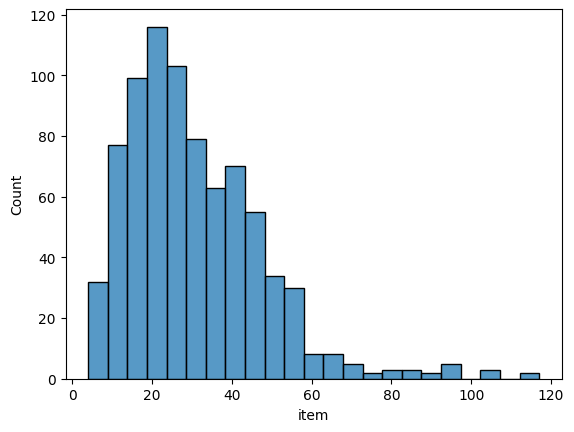

In [5]:
sns.histplot(df.groupby(level=0).item.count())
(df.groupby(level=0).item.count()).min()

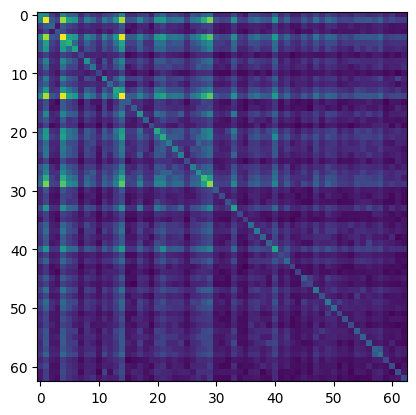

In [6]:
plt.imshow(animals.T@animals)

In [7]:
# sliding_window()
from numpy.lib.stride_tricks import as_strided, sliding_window_view
def arr_cooc(x, n=2):
    # print(x.strides)
    # return as_strided(x, shape=(x.shape[0], n), strides=x.strides*2)
    # print(x.shape)
    return sliding_window_view(x,min(n, x.shape[0]))
# as_strided(df.item.values, shape=(df.length,2), strides=
# (arr_cooc(df.item.values, 3))
# df.groupby(level=0)['item']
animal_occ = (df
#  [df.item.isin(df.item.value_counts(ascending=False).head(100).index.tolist())]
#  [df.item.isin((df.item.value_counts().pipe(lambda s: s[s>20])).index.tolist())]
 .query('category=="animals"')
 .item.astype('category')
)
dummies = np.eye(animal_occ.dtype.categories.shape[0])
roll_X=np.vstack([dummies[arr_cooc(g[1].values, n=10),:].max(axis=1) for g in animal_occ.cat.codes.groupby(level=0)])#[:,]
roll_X = roll_X[:,animal_occ[animal_occ.isin(animals.columns.tolist())].cat.codes.unique()]
# print(animal_occ.cat.codes.sort_values())
# print(animal_cooc.max(axis=0))
# animal_cooc.astype(int).sum(axis=1)
# roll_X=np.array([dummies[ix] for ix in animal_cooc.T])#.sum(axis=1)
# roll_X = roll_X.astype(bool).max(axis=0)
# animal_occ
# animal_occ.cat.codes
# np.eye(animal_occ.dtype.categories.shape[0])[animal_cooc[0]].shape
# animal_occ.cat.codes.unique()
# roll_animals=
# plt.spy(roll_X)
# dummies[arr_cooc(animal_occ.cat.codes.values, n=3)].max(axis=1)#.shape#.shape#max(axis=0)#.sum(axis=0)#.max(axis=0)
roll_X.shape
# animal_occ[animal_occ.isin(animals.columns.tolist())].cat.codes.values

(8124, 63)

<Axes: ylabel='Density'>

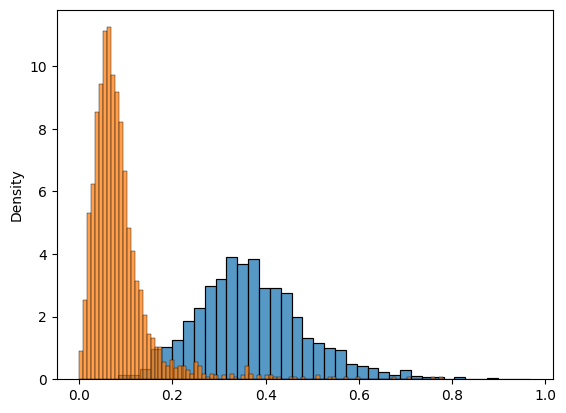

In [12]:
from affinis.associations import ochiai, resource_project, chow_liu, coocur_prob
from affinis.utils import _sq

# X = all_X
X = roll_X


sns.histplot(_sq(ochiai(all_X, pseudocts=0.5)), stat='density')
sns.histplot(_sq(ochiai(roll_X, pseudocts=0.5)), stat='density')
# sns.displot(_sq(resource_project(X)))

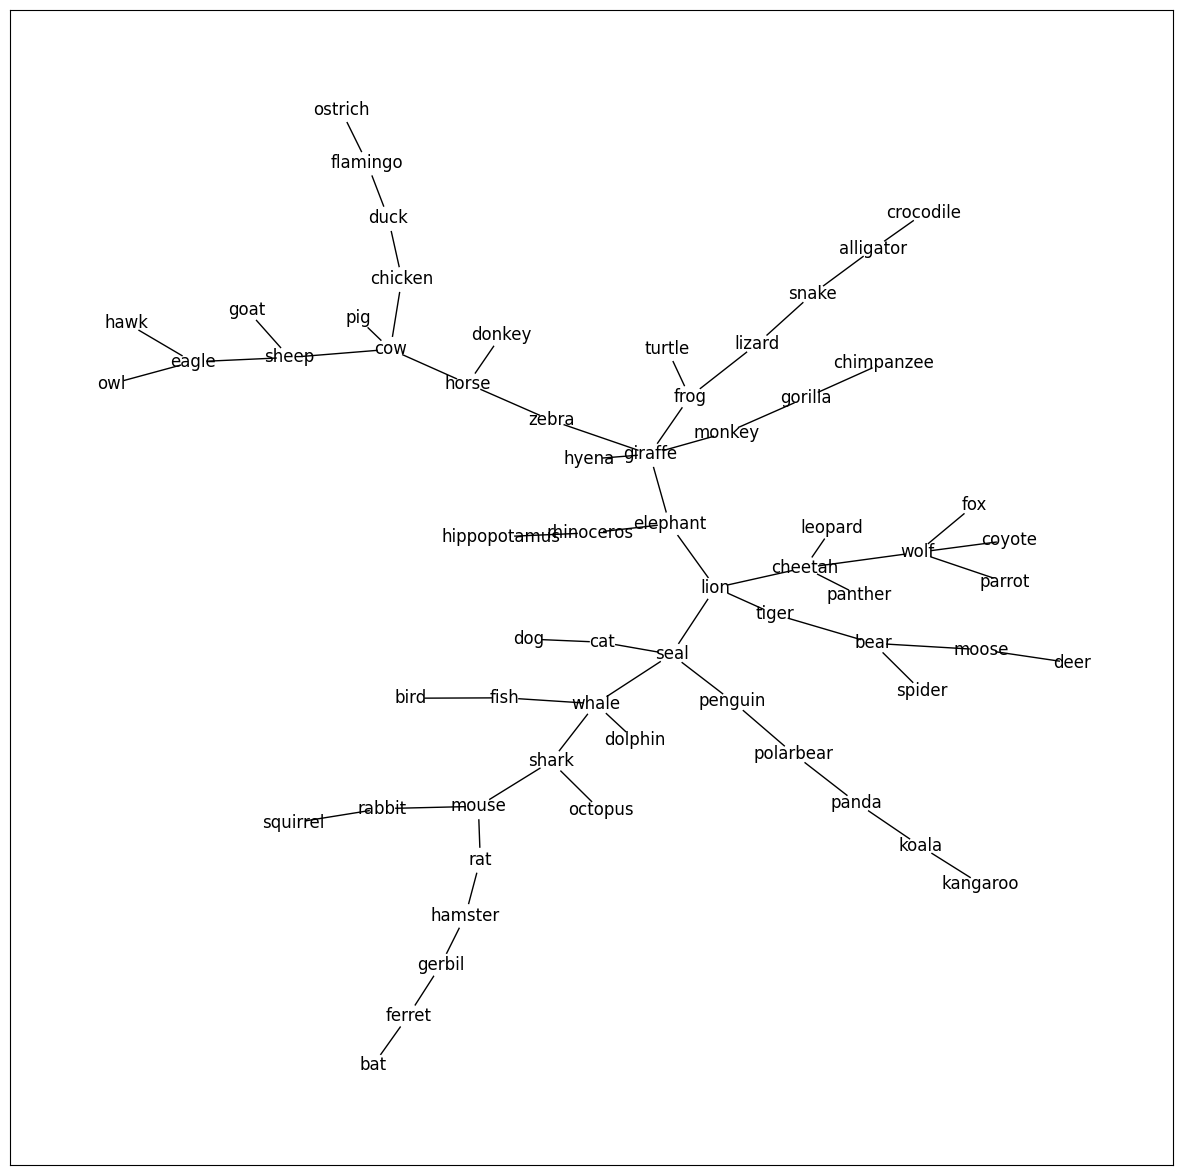

In [13]:
plt.figure(figsize=(15,15))
G = nx.from_pandas_adjacency(pd.DataFrame(chow_liu(X, pseudocts=0.5), index=animals.columns, columns=animals.columns))
pos_tree = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=pos_tree, node_color='w')

True

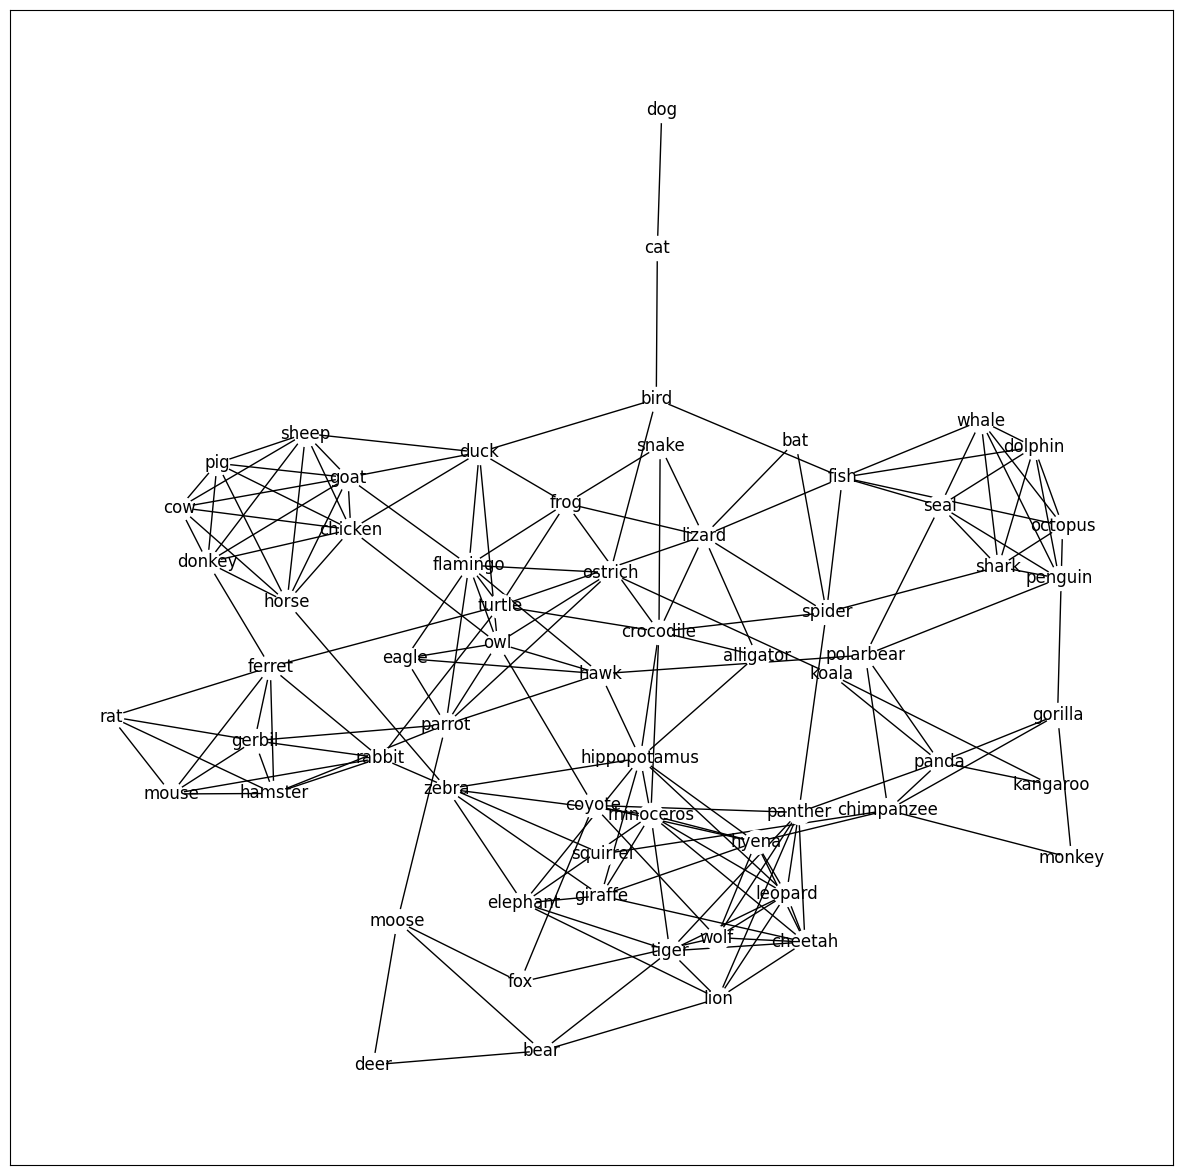

In [14]:



def top_tree_pct(x, mult=1):
    pct=np.percentile(_sq(x), 100-100*mult*2/x.shape[0])
    print(pct)
    return x>=pct
plt.figure(figsize=(15,15))
G = nx.from_pandas_adjacency(pd.DataFrame(_sq(~(min_connected_filter(_sq(sinkhorn(_sq(_sq(X.T@X))))).mask)), index=animals.columns, columns=animals.columns))
# pos_cos = nx.kamada_kawai_layout(G, dist = pd.DataFrame(-np.log(ochiai(X)), columns=animals.columns, index=animals.columns).to_dict())
pos_cos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=pos_cos, node_color='w')
nx.connected.is_connected(G)

True

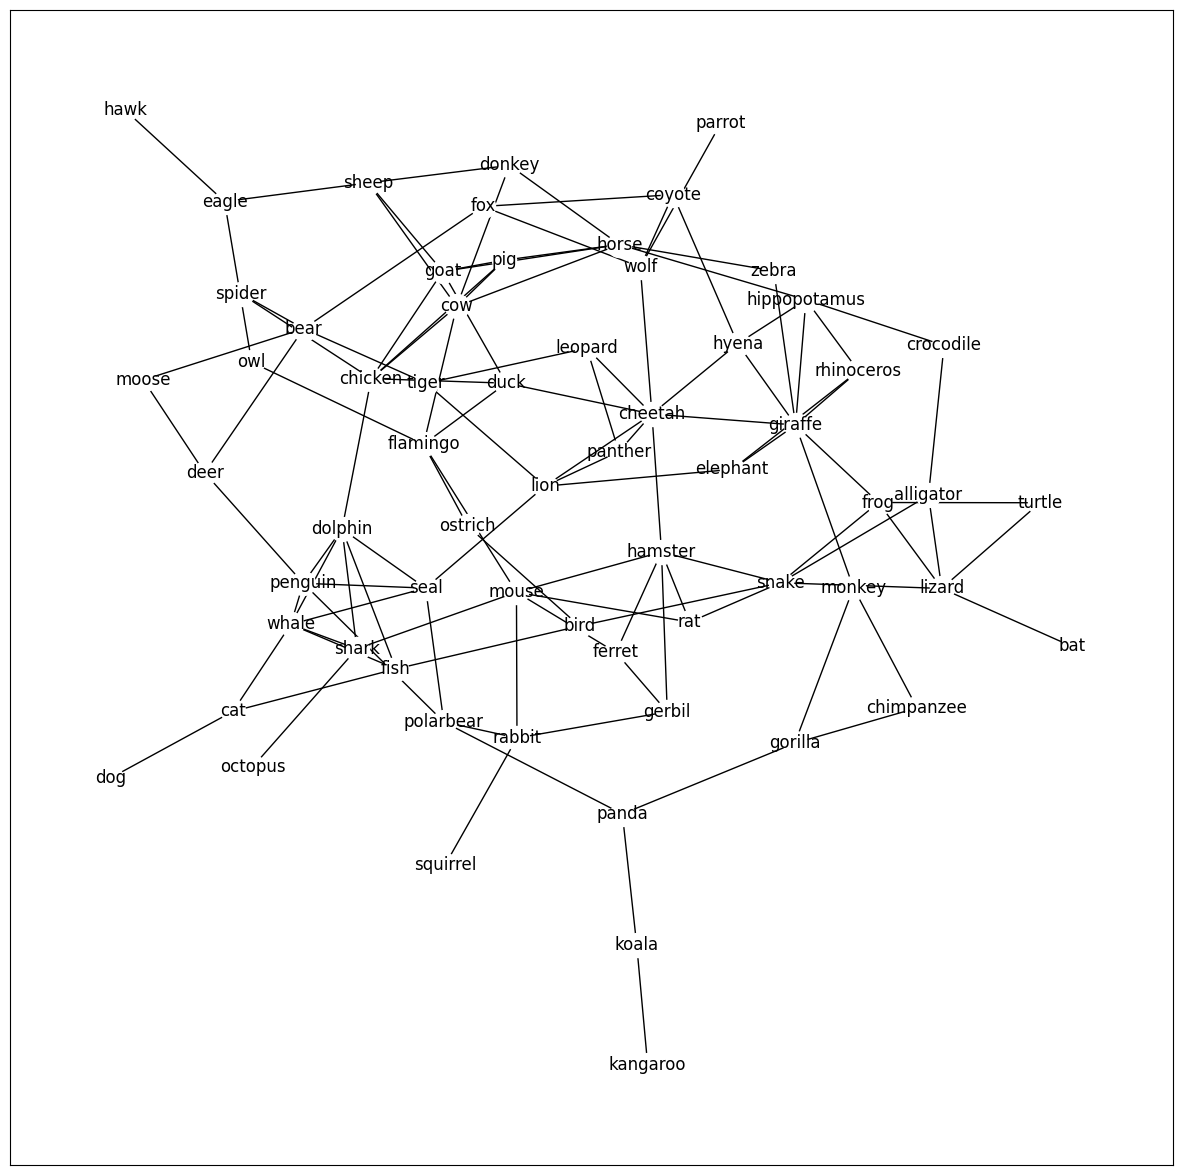

In [15]:
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
# graphical_lasso()
plt.figure(figsize=(15,15))
glasso = (lambda o: o/(1+o))(np.abs(
    _sq(
        GraphicalLassoCV()#covariance='precomputed')
        # .fit(ochiai(X))
        .fit(X)
        .get_precision()
)))
G = nx.from_pandas_adjacency(pd.DataFrame(_sq(~min_connected_filter(glasso).mask), index=animals.columns, columns=animals.columns))
# pos_cos = nx.kamada_kawai_layout(G, dist = pd.DataFrame(-np.log(ochiai(X)), columns=animals.columns, index=animals.columns).to_dict())
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=pos, node_color='w')
nx.connected.is_connected(G)
# glasso
# sns.histplot(glasso)

# _sq(min_connected_filter(glasso)>0)#.shape, X.shape, animals.columns.shape

In [77]:

def get_mask(e_pmf,idx):
    return sprs.coo_array(_sq(e_pmf)*
                          np.multiply.outer(idx,idx))

def unroll_node_obs(X): 
    trirow, tricol = np.triu_indices(n=X.shape[1],k=1)
    return np.einsum('ij,ik->ijk', X, X)[:,trirow, tricol]

def obs_mask_dists(X,d):
    n = X.shape[0]    
    mask = unroll_node_obs(X)
    return np.ma.masked_array(np.multiply.outer(np.ones(n), _sq(d)), mask=~(mask.astype(bool)))

def masked_subset_mst(x_d):
    A = _sq(x_d.compressed())
    T = sprs.csgraph.minimum_spanning_tree(A).todense()
    x_t = np.zeros_like(x_d)
    x_t[~x_d.mask] = _sq(T)
    return x_t

# est_dists = bilinear_dists(sinkhorn(_norm_diag(coocur_prob(roll_X, pseudocts=0.5))))
# est_dists = bilinear_dists(mutual_information(X, pseudocts=0.5))
est_dists = np.abs(-np.log(ochiai(sprs.csr_array(X), pseudocts=0.5)))

# masked_dists = np.ma.array(np.multiply.outer(np.ones(roll_X.shape[0]), _sq(ochiai(roll_X))), mask=unroll_node_obs(~roll_X.astype(bool)))
# masked_dists=obs_mask_dists(X, est_dists)
# masked_subset_mst(masked_dists[0])
# for n,i in enumerate(masked_dists):
#     # print(i.count(), (_sq(np.multiply.outer(roll_X[n], roll_X[n]))).sum(), roll_X[n].sum())
#     print(masked_subset_mst(i)>0)
# _sq(sprs.csgraph.minimum_spanning_tree(_sq(masked_dists[0].compressed())).todense())
# unroll_node_obs(roll_X).shape, np.multiply.outer(np.ones(roll_X.shape[0]), _sq(est_dists)).shape
# masked_dists[1]
# (lambda x: (x,(x**2-x)/2.))(_outer(np.multiply, roll_X[2]).sum())
# (unroll_node_obs(roll_X)[1].astype(bool)).sum()

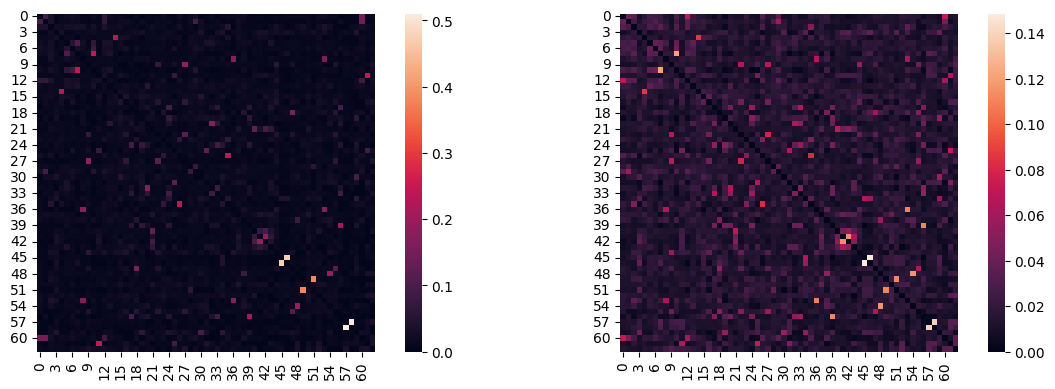

In [21]:
from affinis.associations import high_salience_skeleton
# d,pred = sprs.csgraph.shortest_path(est_dists, return_predecessors=True)
# E_obs = np.array([_sq(sprs.csgraph.reconstruct_path(d, p).astype(bool).toarray()) for p in pred])
# hss = (E_obs.sum(axis=0)+0.5)/(E_obs.shape[0]+1)
f,ax = plt.subplots(ncols=2, figsize=(12,4))
# hss = (E_obs.T*(X.sum(axis=0)/X.shape[0])).T.sum(axis=0)
hss = high_salience_skeleton(X, pseudocts=('zero-sum','min-connect'))
np.histogram(hss)
sns.heatmap(sinkhorn(hss*ochiai(X)), ax=ax[0], square=True)
sns.heatmap(sinkhorn(_sq(_sq(ochiai(X)))), ax=ax[1], square=True)
plt.tight_layout()
# X.sum(axis=0)/X.shape[0]
# np.histogram(E_obs.sum(axis=0), bins=range(15))
# np.array([_sq(sprs.csgraph.reconstruct_path(np.ones_like(est_dists), p).toarray()) for p in pred]).sum(axis=0)

True

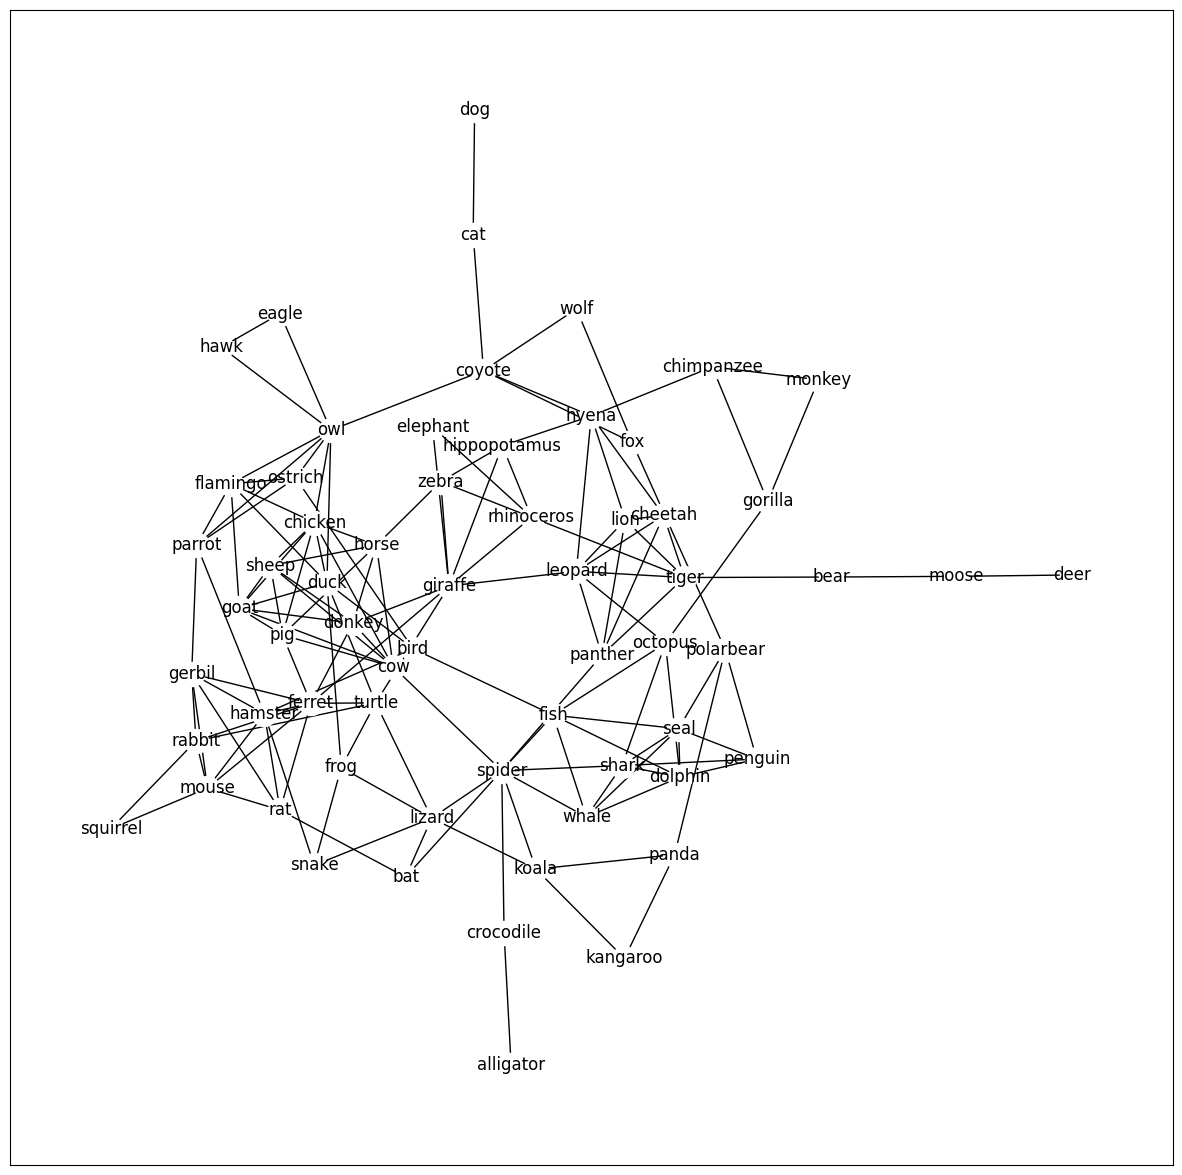

In [31]:
plt.figure(figsize=(15,15))
# G = nx.from_pandas_adjacency(pd.DataFrame(_sq(~min_connected_filter(_sq(sinkhorn(_sq(hss)*ochiai(X)))).mask), index=animals.columns, columns=animals.columns))

G = nx.from_pandas_adjacency(pd.DataFrame(_sq(~min_connected_filter(_sq(sinkhorn(hss*ochiai(X)))).mask), index=animals.columns, columns=animals.columns))
# G = nx.from_pandas_adjacency(pd.DataFrame(hss>0.05, index=animals.columns, columns=animals.columns))

# pos_cos = nx.kamada_kawai_layout(G, dist = pd.DataFrame(-np.log(ochiai(X)), columns=animals.columns, index=animals.columns).to_dict())
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=pos, node_color='w')
nx.connected.is_connected(G)
# np.abs(est_dists)
# np.histogram(E_obs.sum(axis=0), bins=range(15))

In [17]:
from affinis.distance import adjusted_forest_dists

from affinis.associations import SFD_edge_cond_prob, SFD_interaction_prob
evd_L = _sq(SFD_edge_cond_prob(sprs.csr_array(X), pseudocts=('zero-sum','min-connect')))
# mst_post = evd_L*X.shape[0]
post_L=evd_L*_sq(adjusted_forest_dists((lambda a: np.diag(a.sum(axis=0))-a)(_sq(evd_L)), beta=100))
# post_L = _sq(spanning_forests_edge_rate(X))

$P(y|x) = \frac{P(Y\bigcap X)}{P(X)}$

$P(x|y) = \frac{P(Y\bigcap X)}{P(Y)}$

so if $X\subset Y$, then $P(Y\bigcap X)=P(X)$ and $P(X|Y) = \frac{P(X)}{P(Y)}$ and 

$P(X) = P(X|Y)P(Y)$

let X be "probability of an interraction" and Y be "probability of a co-occurrence", we can measure that right side via spanning tree bootstraps, to estimate the left. 

Alternatively, if the co-occurrences are treated as rates (say, counts in a poisson or negative binomial), then we are alternatively deriving our estimate as the thinning parameter for each

True

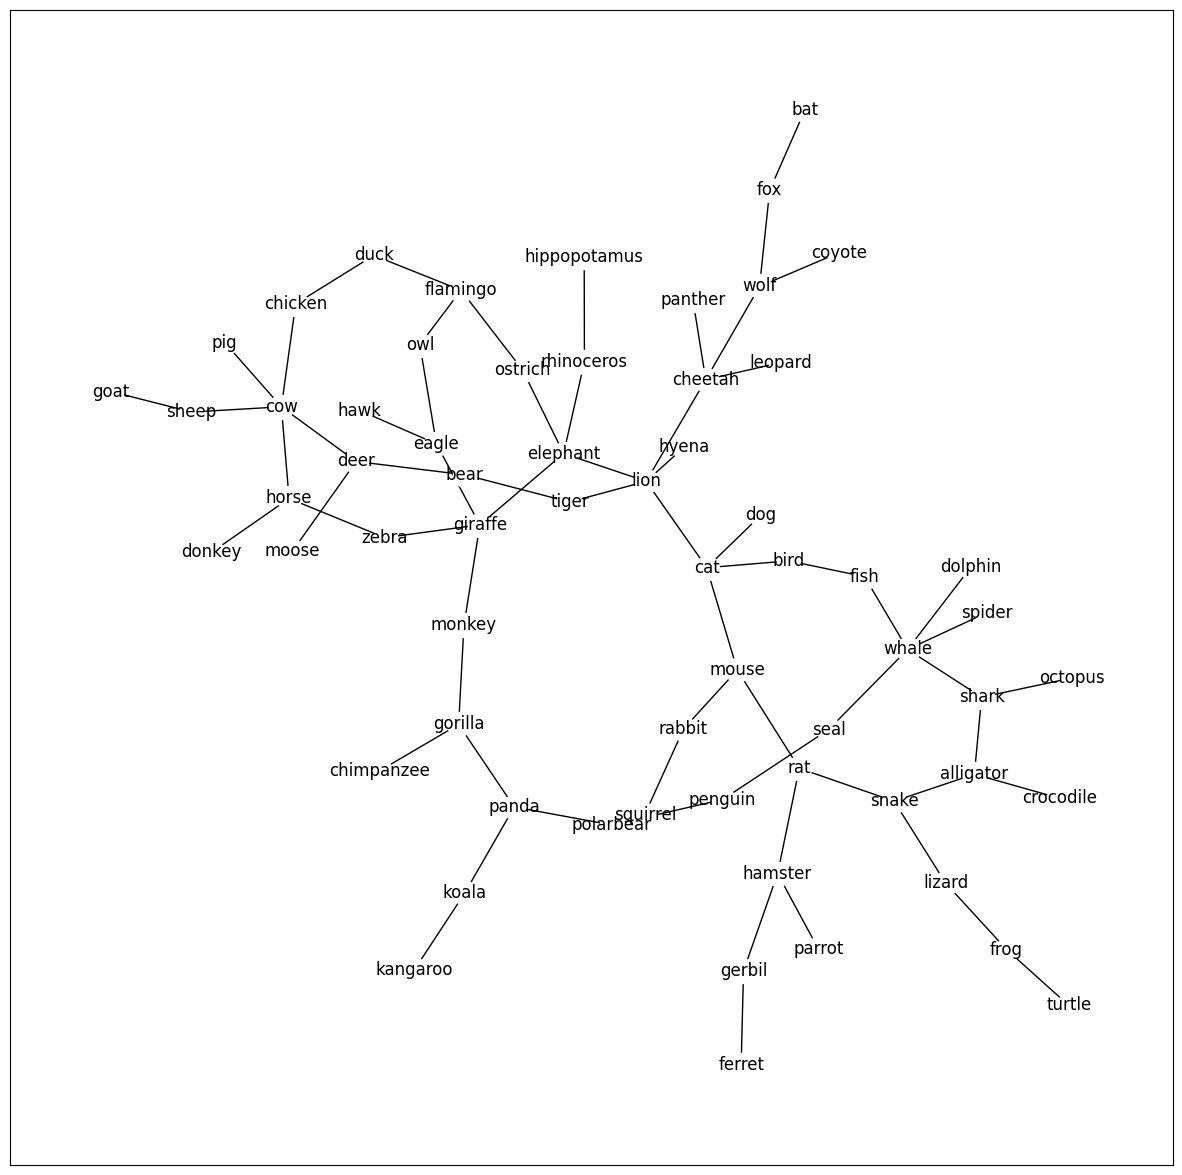

In [20]:
f = plt.figure(figsize=(15,15))

# G = nx.from_pandas_adjacency(pd.DataFrame((minmax(sinkhorn(_sq(post_L)))>0.7).astype(int), index=animals.columns, columns=animals.columns))
# G = nx.from_pandas_adjacency(pd.DataFrame(_sq(_sq(top_tree_pct(_sq(post_L), mult=1.5))), index=animals.columns, columns=animals.columns))
Gthres = min_connected_filter(_sq(Gvals:=(_sq(evd_L))))
G = nx.from_pandas_adjacency(pd.DataFrame(_sq(Gthres.filled(0)), index=animals.columns, columns=animals.columns))
# Gneg = nx.from_pandas_adjacency(pd.DataFrame(
#     _sq(3*(threshold_edges_filter(_sq(Gvals), 0.9) - Gthres.min()).filled(0) + 0.5*Gthres.filled(0)),
#     index = animals.columns, columns = animals.columns,
# ))
# pos = nx.kamada_kawai_layout(G, dist=pd.DataFrame(_sq(-np.log(evd_L)), columns=animals.columns, index=animals.columns).to_dict())
pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G, iterations=1000, k=2)

nx.draw_networkx(G, pos=pos, node_color='w')
# nx.draw_networkx_edges(G, pos=pos)
# nx.draw_networkx_labels(G, pos=pos, bbox = dict(facecolor = "xkcd:cement", edgecolor=None, joinstyle='round'))
# plt.savefig('animals.svg')
# list(G.neighbors('spider'))
nx.connected.is_connected(G)
# fig


<Axes: >

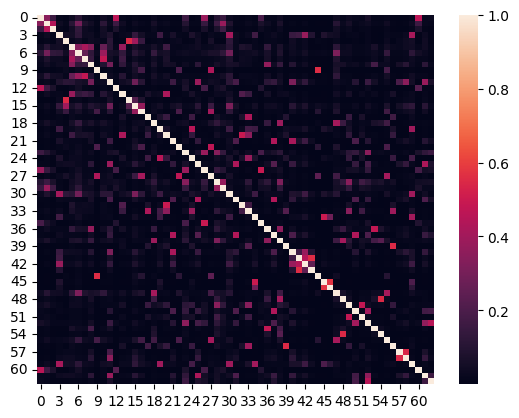

In [105]:
from affinis.distance import adjusted_forest_dists, generalized_graph_dists
sns.heatmap(np.exp(-generalized_graph_dists(edge_mask_to_laplacian(min_connected_filter(evd_L)), beta=2)))

<Axes: >

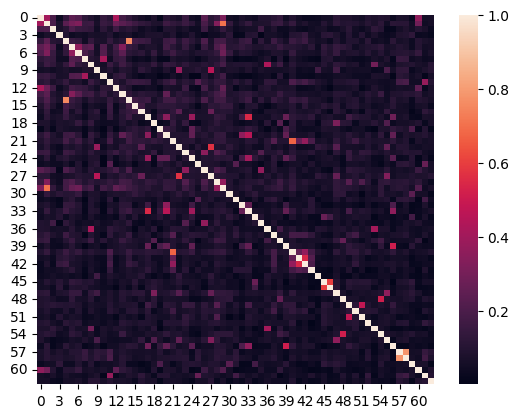

In [100]:
sns.heatmap(ochiai(X))

In [25]:
Ttest = sprs.csgraph.minimum_spanning_tree(sprs.dok_array(_sq(Gthres.filled(0)))).todok()

Ttest.nonzero()

# list(zip(*sprs.coo_array(X).nonzero()))

(array([ 0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  3,  4,  4,  5,
         5,  5,  6,  7,  7,  7,  8,  9,  9,  9, 10, 10, 11, 12, 13, 13, 14,
        15, 16, 17, 18, 18, 19, 20, 20, 22, 22, 23, 24, 25, 25, 27, 29, 29,
        29, 29, 30, 31, 33, 34, 34, 35, 37, 37, 38, 40, 43, 43, 45, 47, 49,
        50, 61, 62, 62, 66, 71], dtype=int32),
 array([13, 32, 52,  2,  4, 11, 18, 22, 28, 48, 59, 29, 43, 53, 39, 57,  8,
        34, 49, 47,  9, 25, 41, 56, 11, 46, 66, 11, 21, 26, 20, 17, 50, 37,
        74, 20, 62, 51, 54, 28, 24, 42, 31, 44, 31, 36, 34, 60, 65, 30, 47,
        55, 68, 73, 63, 41, 58, 65, 41, 40, 42, 47, 48, 66, 70, 57, 67, 64,
        74, 67, 66, 72, 69, 74], dtype=int32))

In [26]:
row,col = Ttest.nonzero()
Ttest[col,row] = Ttest[row,col]
Ttest.nonzero()

(array([ 0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  3,  4,  4,  5,
         5,  5,  6,  7,  7,  7,  8,  9,  9,  9, 10, 10, 11, 12, 13, 13, 14,
        15, 16, 17, 18, 18, 19, 20, 20, 22, 22, 23, 24, 25, 25, 27, 29, 29,
        29, 29, 30, 31, 33, 34, 34, 35, 37, 37, 38, 40, 43, 43, 45, 47, 49,
        50, 61, 62, 62, 66, 71, 13, 32, 52,  2,  4, 11, 18, 22, 28, 48, 59,
        29, 43, 53, 39, 57,  8, 34, 49, 47,  9, 25, 41, 56, 11, 46, 66, 11,
        21, 26, 20, 17, 50, 37, 74, 20, 62, 51, 54, 28, 24, 42, 31, 44, 31,
        36, 34, 60, 65, 30, 47, 55, 68, 73, 63, 41, 58, 65, 41, 40, 42, 47,
        48, 66, 70, 57, 67, 64, 74, 67, 66, 72, 69, 74], dtype=int32),
 array([13, 32, 52,  2,  4, 11, 18, 22, 28, 48, 59, 29, 43, 53, 39, 57,  8,
        34, 49, 47,  9, 25, 41, 56, 11, 46, 66, 11, 21, 26, 20, 17, 50, 37,
        74, 20, 62, 51, 54, 28, 24, 42, 31, 44, 31, 36, 34, 60, 65, 30, 47,
        55, 68, 73, 63, 41, 58, 65, 41, 40, 42, 47, 48, 66, 70, 57, 67, 64,
        74, 67, 6

In [27]:
# Ttest.keys()
# Ttest[0].values()
# sprs.dok_matrix(X)[0]
# Ttest
from itertools import combinations
completes = list((np.array(list(combinations(i.nonzero()[1],2))).T for i in sprs.coo_matrix(X).todok()))
completes[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 7],
       [1, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 4,
        5, 6, 7, 8, 5, 6, 7, 8, 6, 7, 8, 7, 8, 8]], dtype=int32)

In [28]:
# sprs.coo_array((est_dists[completes[0][0],completes[0][1]], (completes[0][0], completes[0][1])), shape=(5,5)).toarray().round(2)

In [30]:
# %timeit _sq(sprs.csgraph.minimum_spanning_tree(_sq(est_dists[completes[0][0],completes[0][1]])).toarray())>0

In [31]:
# %timeit _sq(sprs.csgraph.minimum_spanning_tree(_sq(_sq(est_dists)*_sq(np.multiply.outer(X[0], X[0])))))

In [32]:
spX = sprs.coo_matrix(X).todok()
x = spX[:100,0]
%timeit (x@x.T)>0

%timeit np.multiply.outer(X[:100,0], X[:100,0])>0

%timeit np.array(list(combinations(x.nonzero()[1],2))).T
# plt.spy(X, aspect=0.01)
# (spX[:1000,0]@spX[:1000,0].T)>0

648 µs ± 3.19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
16.9 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
173 µs ± 809 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [84]:
from tqdm import tqdm
from affinis.utils import _outer
def _filter_edgeweight_to_tree(e):
    return _sq(sprs.csgraph.minimum_spanning_tree(_sq(e)).toarray())>0

def better_sfep(X, prior=ochiai, pseudocts=0.5):
    est_dists = -np.log(prior(X, pseudocts=pseudocts))
    big_N = X.shape[1]>=1e3
    if sprs.issparse(X) and (not big_N):
        X_obs = X.toarray() 
    elif big_N:
        X_obs = sprs.coo_matrix(X).todok()
    else: 
        X_obs = X
    # X_obs =  if ( else X.toarray()
    # X_obs = .todok() if  else X
    # idx_gen = tqdm(np.array(list(combinations(x.nonzero()[1],2))).T for x in sprs.coo_matrix(X).todok() if x.sum()>1)
    idx_gen = (sprs.coo_array(est_dists*((x.T@x if big_N else _outer(np.multiply, x)))) for x in X_obs)
    E_obs = sprs.coo_array([_sq((sprs.csgraph.minimum_spanning_tree(a)>0).todense()) for a in idx_gen])
    # row_col = np.concatenate([idx.T[filter_edgeweight_to_tree(est_dists[idx[0],idx[1]])] for idx in idx_gen if idx.shape[1]>1]).T
    # return sprs.coo_array((np.ones(row_col.shape[1]), (row_col[0],row_col[1])), shape=(X.shape[1],X.shape[1]))
    return E_obs
    # row_col = [idx.T[filter_edgeweight_to_tree(est_dists[idx[0],idx[1]])] for idx in idx_gen]
    # row_col = list(idx_gen)
    # row_col = [(idx, est_dists[idx[0],idx[1]]) for idx in idx_gen if idx.shape[1]>1]
    # return row_col
E_obs = better_sfep(X)
# E_obs

In [33]:
# (E_obs.T@E_obs)@(spX.T@E_obs).
from affinis.utils import sparse_adj_to_incidence, _norm_diag
from affinis.associations import _spanning_forests_obs_bootstrap
# n1,n2 = np.triu(nx.adjacency_matrix(G).todense()).nonzero()#,_sq(np.triu_indices_from(X.T@X, k=1)[0])
# e = np.ma.nonzero(_sq(nx.adjacency_matrix(G).todense()))[0]
# B = sprs.coo_array((np.concatenate([ones:=np.ones(e.shape[0]),-ones]), (np.concatenate([e,e]),np.concatenate([n1,n2]))), shape=(_sq(nx.adjacency_matrix(G).todense()).shape[0], X.shape[1]))
def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags
E_obs = _spanning_forests_obs_bootstrap(X)
n1, n2 = np.triu(_sq(evd_L)).nonzero()
# print(n1.shape)
e = np.ma.nonzero(evd_L)[0]
print(e.shape, n1.shape, n2.shape)
B = sprs.coo_array((np.concatenate([evd_L, -evd_L]), (np.concatenate([e,e]),np.concatenate([n1,n2]))), shape=(e.shape[0], X.shape[1]))

# np.diag((B.T@B).toarray())==np.diag(nx.laplacian_matrix(G).toarray()).round(1)
Xest=(E_obs@(np.abs(B))).toarray()

# ((np.abs(B).T@E_obs.T>0).T.toarray().astype(int)!=X.astype(int)).sum(axis=0)
# _norm_diag((B.T@B).toarray())

(1953,) (1953,) (1953,)


<Axes: ylabel='Count'>

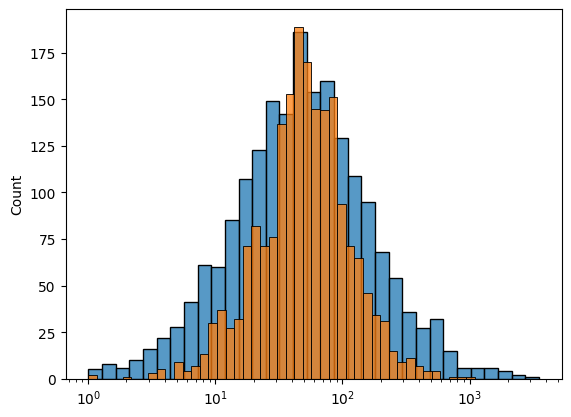

In [34]:
# _sq(np.diag((E_obs.astype(int).T@E_obs).toarray()))

# _sq(E_obs.sum(axis=0))

# Xest=(E_obs@(B!=0)).astype(int)
sns.histplot(_sq(Xest.T@Xest+1), log_scale=True)
sns.histplot(_sq(X.T@X+1), log_scale=True)

array([ 4,  3,  2,  1,  0,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 15, 14,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 29, 28, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 49, 48,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

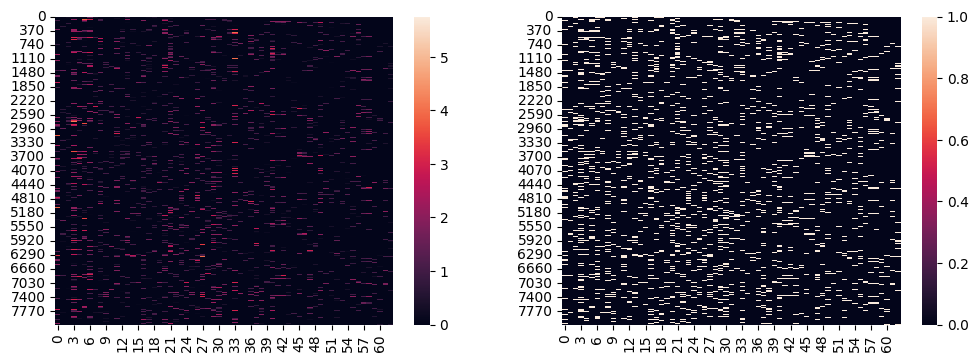

In [56]:
f,ax = plt.subplots(ncols=2, figsize=(12,4))
sns.heatmap(Xest[:, np.lexsort(-(Xest>0).astype(int)[::-1])], ax=ax[0])
sns.heatmap(X[:, np.lexsort(-X[::-1])], ax=ax[1])
np.lexsort(-X[::-1])
# np.argsort(Xest.sum(axis=0))

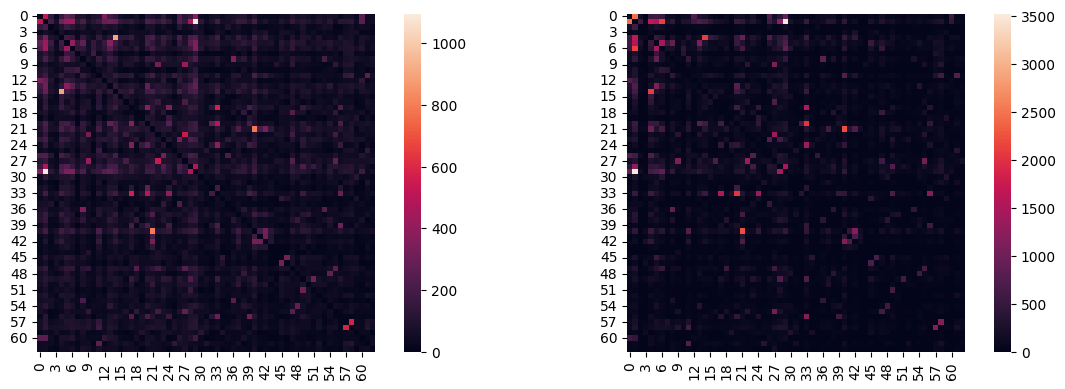

In [35]:
# sns.heatmap(ochiai(X))
f,ax = plt.subplots(ncols=2, figsize=(12,4))
sns.heatmap(_sq(_sq(X.T@X)), ax=ax[0], square=True)
sns.heatmap(_sq(_sq(Xest.T@Xest)), ax=ax[1], square=True)
plt.tight_layout()

<Axes: >

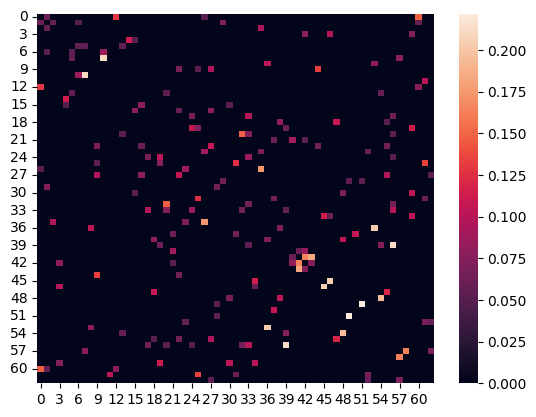

In [36]:
# sns.heatmap(np.cov(Xest))
sns.heatmap(_sq(min_connected_filter(_sq(sinkhorn(_sq(_sq(ochiai(Xest)))))).filled(0)))
# sns.heatmap(_sq(min_connected_filter(_sq(ochiai(Xest))).filled(0)))

In [89]:
# spanning_forests_edge_prob(Xest>)
# sns.histplot(np.ma.masked_less_equal(Xest, 0).flatten())

# E_obs

True

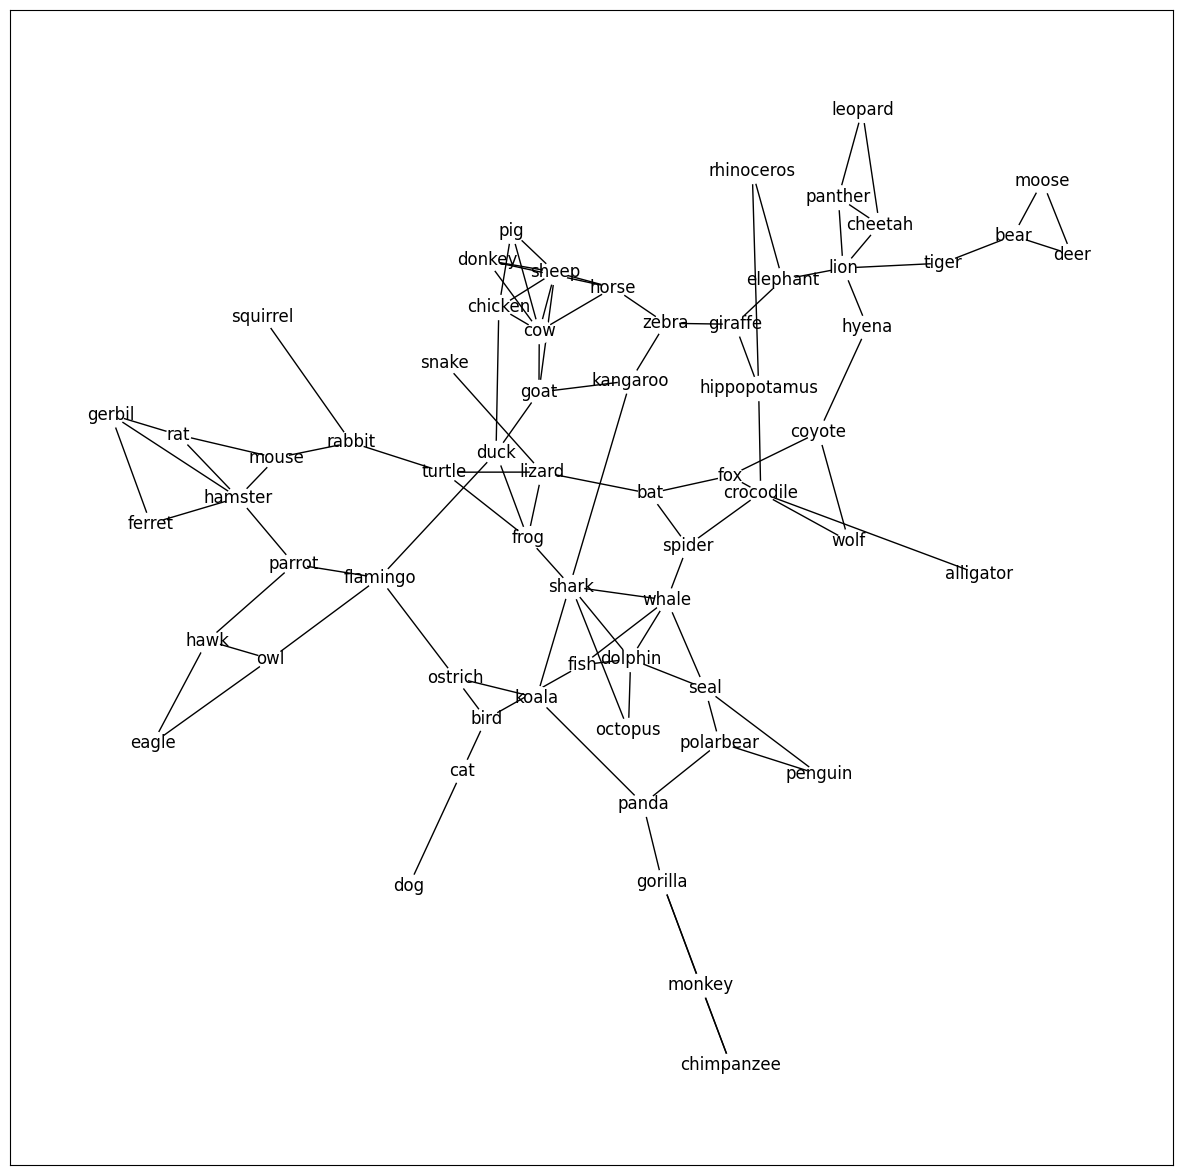

In [37]:
f = plt.figure(figsize=(15,15))

# G = nx.from_pandas_adjacency(pd.DataFrame((minmax(sinkhorn(_sq(post_L)))>0.7).astype(int), index=animals.columns, columns=animals.columns))
# G = nx.from_pandas_adjacency(pd.DataFrame(_sq(_sq(top_tree_pct(_sq(post_L), mult=1.5))), index=animals.columns, columns=animals.columns))
Gest = min_connected_filter(_sq(sinkhorn(_sq(_sq(Xest.T@Xest)))))
G = nx.from_pandas_adjacency(pd.DataFrame(_sq(Gest.filled(0)), index=animals.columns, columns=animals.columns))
# Gneg = nx.from_pandas_adjacency(pd.DataFrame(
#     _sq(3*(threshold_edges_filter(_sq(Gvals), 0.9) - Gthres.min()).filled(0) + 0.5*Gthres.filled(0)),
#     index = animals.columns, columns = animals.columns,
# ))
# pos = nx.kamada_kawai_layout(G, dist=pd.DataFrame(1-ochiai(Xest), columns=animals.columns, index=animals.columns).to_dict())
pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G, iterations=1000, k=2)

nx.draw_networkx(G, pos=pos, node_color='w')
# nx.draw_networkx_edges(G, pos=pos_cos)
# mx.
# nx.draw_networkx_labels(G, pos=pos_cos, bbox = dict(facecolor = "xkcd:cement", edgecolor=None, joinstyle='round'))
# plt.savefig('animals.svg')
# list(G.neighbors('spider'))
nx.connected.is_connected(G)

In [34]:
Xfilt = (E_obs.todense()[:,~Gthres.mask]@nx.incidence_matrix(G).T > 0).astype(int)
it_L = spanning_forests_edge_prob(Xfilt)

ValueError: dimension mismatch

In [ ]:
f,ax = plt.subplots(ncols=2, figsize=(12,4))
sns.heatmap(it_L, ax=ax[0])
sns.heatmap(_sq(evd_L), ax=ax[1])

In [ ]:
from affinis.plots import hinton

hinton(_sq(evd_L))

In [ ]:
np.linalg.norm((X-(Xest>0)),ord='fro'), np.linalg.norm(X,ord='fro'), np.linalg.norm(Xest>0,ord='fro')

In [228]:
import yappi
yappi.clear_stats()
yappi.set_clock_type("wall") # Use set_clock_type("wall") for wall time
yappi.start()
better_sfep(X)
yappi.stop()
yappi.get_func_stats().print_all()
yappi.get_thread_stats().print_all()


Clock type: WALL
Ordered by: totaltime, desc

name                                  ncall  tsub      ttot      tavg      
..:3514 ZMQInteractiveShell.run_code  1      0.000012  5.134156  5.134156
..l_3663594/4233301675.py:1 <module>  2/1    0.000007  5.134139  2.567069
..663594/1263782606.py:6 better_sfep  1      0.001803  5.134132  5.134132
..663594/1263782606.py:19 <listcomp>  1      0.039351  5.085891  5.085891
..mpressed.py:25 csr_matrix.__init__  324..  0.229845  2.989200  0.000092
..4 _UnixSelectorEventLoop._run_once  4      0.000109  2.325256  0.581314
..ectors.py:452 EpollSelector.select  4      0.000035  2.324344  0.581086
..ph/_validation.py:9 validate_graph  8124   0.029619  1.644139  0.000202
..py:1269 coo_array._get_index_dtype  80996  0.249408  1.479663  0.000018
..ssed.py:135 csr_array.check_format  32496  0.427120  1.430900  0.000044
..3663594/1263782606.py:18 <genexpr>  8125   0.048173  1.172404  0.000144
..se/_sputils.py:147 get_index_dtype  80996  0.733940  1.140306

In [224]:
# %timeit spanning_forests_edge_prob(X)
yappi.clear_stats()
yappi.set_clock_type("wall")
yappi.start()
spanning_forests_edge_prob(X)
yappi.stop()
yappi.get_func_stats().print_all()
yappi.get_thread_stats().print_all()


Clock type: WALL
Ordered by: totaltime, desc

name                                  ncall  tsub      ttot      tavg      
..:3514 ZMQInteractiveShell.run_code  1      0.000014  4.409563  4.409563
..el_3663594/832412967.py:1 <module>  2/1    0.000007  4.409544  2.204772
...py:191 spanning_forests_edge_prob  1      0.001704  4.409537  4.409537
..nis/associations.py:206 <listcomp>  1      0.095876  4.360579  4.360579
..mpressed.py:25 csr_matrix.__init__  243..  0.166141  2.314031  0.000095
..ph/_validation.py:9 validate_graph  8124   0.030097  1.656756  0.000204
..finis/associations.py:197 get_mask  8124   0.044565  1.284241  0.000158
..py:1269 coo_array._get_index_dtype  64750  0.197535  1.186425  0.000018
..se/_base.py:343 coo_array.asformat  8124   0.016450  1.096959  0.000135
..ssed.py:135 csr_array.check_format  24372  0.322262  1.086060  0.000045
..sparse/_coo.py:380 coo_array.tocsr  8124   0.084516  1.075040  0.000132
..rse/_coo.py:132 coo_array.__init__  8126   0.108975  1.074641

<Axes: >

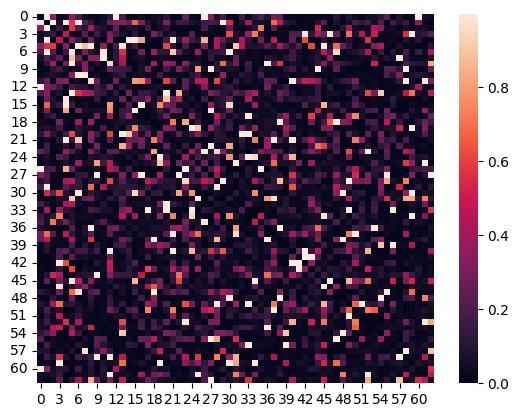

In [214]:
sns.heatmap(_sq((E_obs.sum(axis=0)+0.5)/_sq(X.T@X+1)))
# _sq(E_obs.todense())

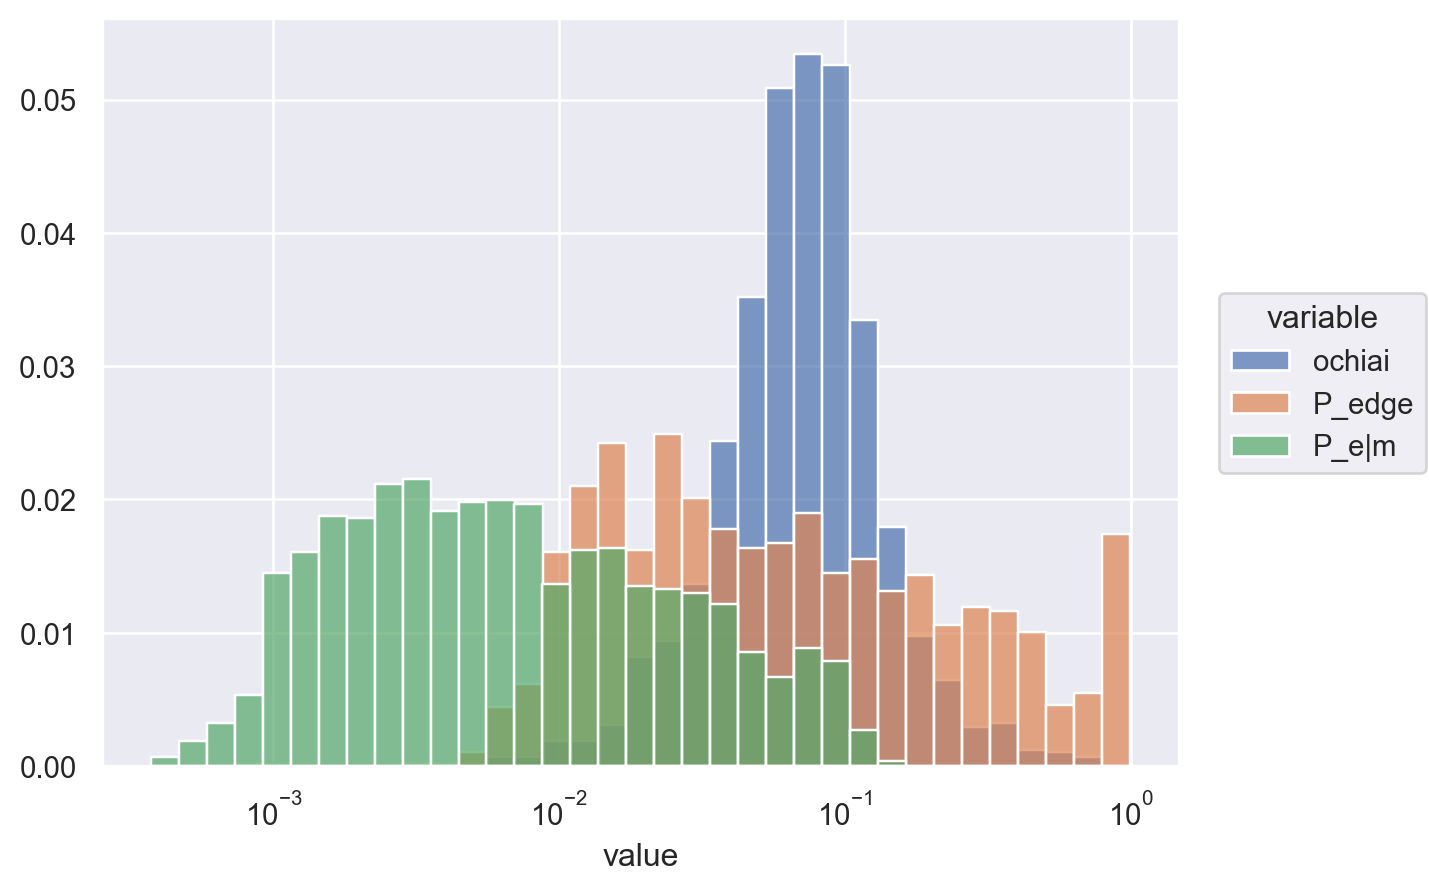

In [18]:
# mst_post/X.shape[1], 
import seaborn.objects as so
from affinis.utils import edge_mask_to_laplacian
# _sq(coocur_prob(X,pseudocts=0.5))*(E_obs.sum(axis=0)+0.5)/(unroll_node_obs(X).sum(axis=0)+1)
# sns.heatmap(_norm_diag((lambda a: np.diag(a.sum(axis=0))-a)(_sq(mst_post))))
# sns.histplot(np.ma.masked_less( -_sq(_norm_diag((lambda a: np.diag(a.sum(axis=0))-a)(_sq(mst_post)))),0.1))
# sns.histplot(mst_post,discrete=True)
# mst_post

# for scores in [
so.Plot(pd.DataFrame({
    'ochiai': _sq(ochiai(X, pseudocts=0.5)),
    'P_edge': evd_L,
    # mst_post,
    'P_e|m': post_L,
}).melt(), x='value', color='variable'
).add(
    so.Bars(), 
    so.Hist(stat='proportion'), 
    # so.Stack() 
).scale(x='log')
# ]:
    # sns.histplot(scores, stat='density', log_scale=True, element='step', fill=False)
    # sns.histplot(np.ma.masked_less(evd_L, 0.01), stat='density', log_scale=True)
# sns.histplot()
# sns.histplot(np.ma.masked_less(post_L, 0.01), stat='density', log_scale=True)
# sns.histplot(_sq(ochiai(X, pseudocts=0.5)), stat='density', log_scale=True)
# sns.histplot(np.ma.masked_less(_sq(_norm_diag(forest(edge_mask_to_laplacian(np.ma.masked_less(evd_L, 0.1)), beta=1))), 0.1), stat='density')

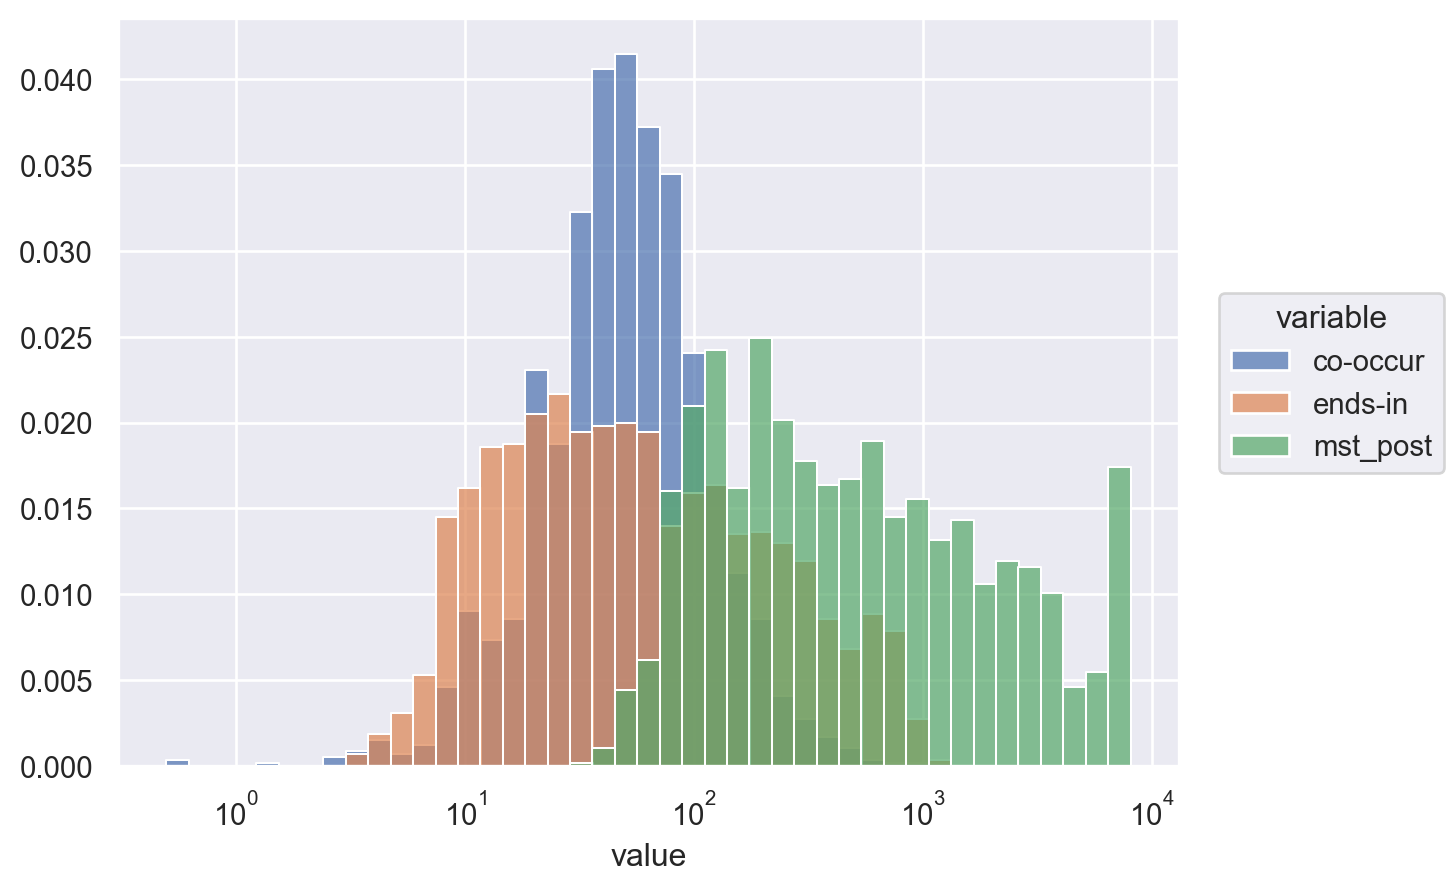

In [19]:
# np.sort(X.shape[0]*post_L)
so.Plot(pd.DataFrame({
    'co-occur': X.shape[0]*_sq(coocur_prob(X, pseudocts=0.5)),
    'ends-in': X.shape[0]*post_L,
    'mst_post': mst_post,
    # 'same-tree': X.shape[0]*_sq(_norm_diag(forest((lambda a: np.diag(a.sum(axis=0))-a)(_sq(evd_L)), beta=1))),
}).melt(), x='value', color='variable'
).add(
    so.Bars(), 
    so.Hist(stat='proportion'), 
    # so.Stack() 
).scale(x='log')

# sns.histplot(_sq(X.T@X), log_scale=True)
# sns.histplot(X.shape[0]*post_L, log_scale=True, fill=False)
# sns.histplot(X.shape[0]*_sq(_norm_diag(forest((lambda a: np.diag(a.sum(axis=0))-a)(_sq(evd_L)), beta=5))))

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


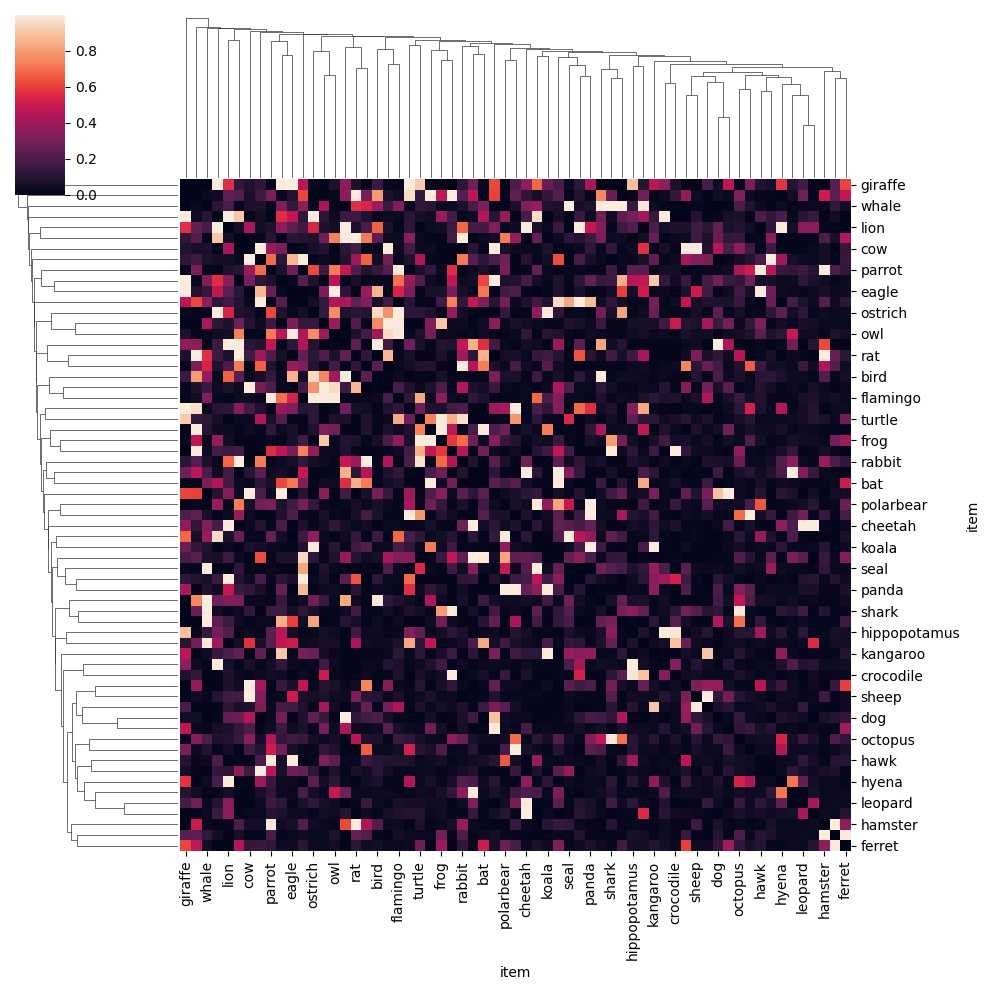

In [20]:
sns.clustermap(pd.DataFrame(_sq(evd_L), columns=animals.columns, index=animals.columns), 
               # mask = _sq(min_connected_filter(evd_L).mask)
              )
# sns.heatmap(_norm_diag(1-forest(edge_mask_to_laplacian(np.ma.masked_less(evd_L, 0.1)), beta=1)))
# sns.heatmap(forest(edge_mask_to_laplacian(np.ma.masked_less(evd_L, 0.1)), beta=1)/np.sqrt(1-_outer(np.multiply, 1-np.diag(forest(edge_mask_to_laplacian(np.ma.masked_less(evd_L, 0.1)), beta=1)))))

In [23]:
# pd.DataFrame(_sq(evd_L), columns=animals.columns, index=animals.columns).to_dict()
# pd.Series.to_dict()

In [270]:
A=_sq(_sq(X.T@X))

A.argmax(axis=0)
A.max(axis=0)

array([ 524., 1096.,  198.,  121.,  899.,   58.,  419.,  441.,  177.,
        362.,  416.,   82.,  177.,  259.,  342.,  380.,  899.,  152.,
        208.,  571.,  230.,  161.,  154.,  149.,  501.,  182.,  791.,
         83.,   99.,  541.,  326.,  391.,  190.,   87.,   82.,   82.,
        187.,   93.,  235.,  326.,  247.,   73.,  541.,  480.,   75.,
       1096.,  190.,  109.,  267.,  571.,  142.,  219.,   67.,   65.,
        362.,  217.,   99.,  154.,  107.,  311.,  791.,  308.,  332.,
        136.,   82.,  171.,   79.,  329.,  329.,  254.,  280.,  306.,
        168.,  168.,  306.,   52.,   99.,  151.,  240.,  280.,  150.,
        267.,   82.,  311.,   95.,  105.,   92.,   71.,   55.,   82.,
        578.,  578.,  247.,  152.,  152.,   64.,   92.,  118.,  103.,
        133.,  187.,  259.,  113.,  113.,  171.,  190.,  225.,   48.,
        259.,   90.,  123.,  110.,  170.,   82.,  121.,   77.,   95.,
         74.,   92.,   37.,   82.,   95.,  136.,   49.,   72.,   76.,
         57.,  136.,

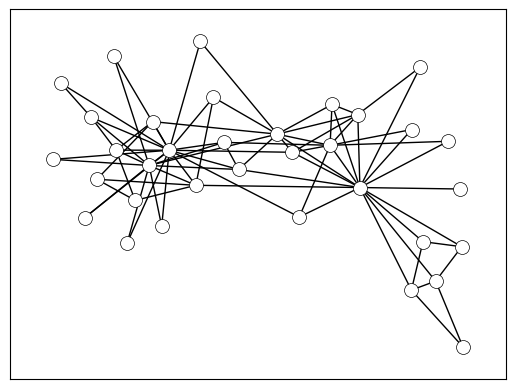

In [72]:
nx.draw_networkx_nodes(
    K:=nx.karate_club_graph(), pos=(testpos:=nx.spring_layout(K)), 
    node_color='white', edgecolors='k', 
    node_size=100, linewidths=0.5,
)
nx.draw_networkx_edges(
    K, pos=testpos,
)

{0: 'cheetah',
 1: 'lion',
 2: 'hyena',
 3: 'parrot',
 4: 'cat',
 5: 'giraffe',
 6: 'elephant',
 7: 'hippopotamus',
 8: 'monkey',
 9: 'shark',
 10: 'rhinoceros',
 11: 'snake',
 12: 'leopard',
 13: 'zebra',
 14: 'dog',
 15: 'bird',
 16: 'fish',
 17: 'pig',
 18: 'polarbear',
 19: 'duck',
 20: 'horse',
 21: 'mouse',
 22: 'dolphin',
 23: 'fox',
 24: 'chicken',
 25: 'frog',
 26: 'wolf',
 27: 'whale',
 28: 'bear',
 29: 'tiger',
 30: 'ostrich',
 31: 'turtle',
 32: 'donkey',
 33: 'cow',
 34: 'owl',
 35: 'coyote',
 36: 'gorilla',
 37: 'rabbit',
 38: 'panda',
 39: 'goat',
 40: 'rat',
 41: 'gerbil',
 42: 'hamster',
 43: 'ferret',
 44: 'octopus',
 45: 'eagle',
 46: 'hawk',
 47: 'penguin',
 48: 'koala',
 49: 'deer',
 50: 'squirrel',
 51: 'moose',
 52: 'bat',
 53: 'chimpanzee',
 54: 'kangaroo',
 55: 'seal',
 56: 'sheep',
 57: 'crocodile',
 58: 'alligator',
 59: 'flamingo',
 60: 'panther',
 61: 'lizard',
 62: 'spider'}

In [200]:
# _sq((threshold_edges_filter(_sq(Gvals), 0.8) - Gthres.min()).filled(0))
nx.kamada_kawai_layout(G)

{'cheetah': array([0.1370444 , 0.35764964]),
 'lion': array([0.02327738, 0.17686164]),
 'hyena': array([0.09645275, 0.23806374]),
 'parrot': array([ 0.35206909, -0.65653282]),
 'cat': array([0.1390281 , 0.02298124]),
 'giraffe': array([-0.29431747,  0.09967727]),
 'elephant': array([-0.1343438 ,  0.22653738]),
 'hippopotamus': array([-0.0949707 ,  0.57694478]),
 'monkey': array([-0.32461975, -0.07930922]),
 'shark': array([ 0.66518763, -0.20761533]),
 'rhinoceros': array([-0.09459386,  0.39046453]),
 'snake': array([ 0.49709023, -0.39303004]),
 'leopard': array([0.28009482, 0.38824283]),
 'zebra': array([-0.47581587,  0.0767751 ]),
 'dog': array([0.24244725, 0.11632704]),
 'bird': array([0.29671019, 0.03563657]),
 'fish': array([0.44177627, 0.00737789]),
 'pig': array([-0.78260781,  0.42283623]),
 'polarbear': array([-0.04114286, -0.43535757]),
 'duck': array([-0.49876226,  0.58004015]),
 'horse': array([-0.65881396,  0.14602821]),
 'mouse': array([ 0.19756988, -0.15934142]),
 'dolphin

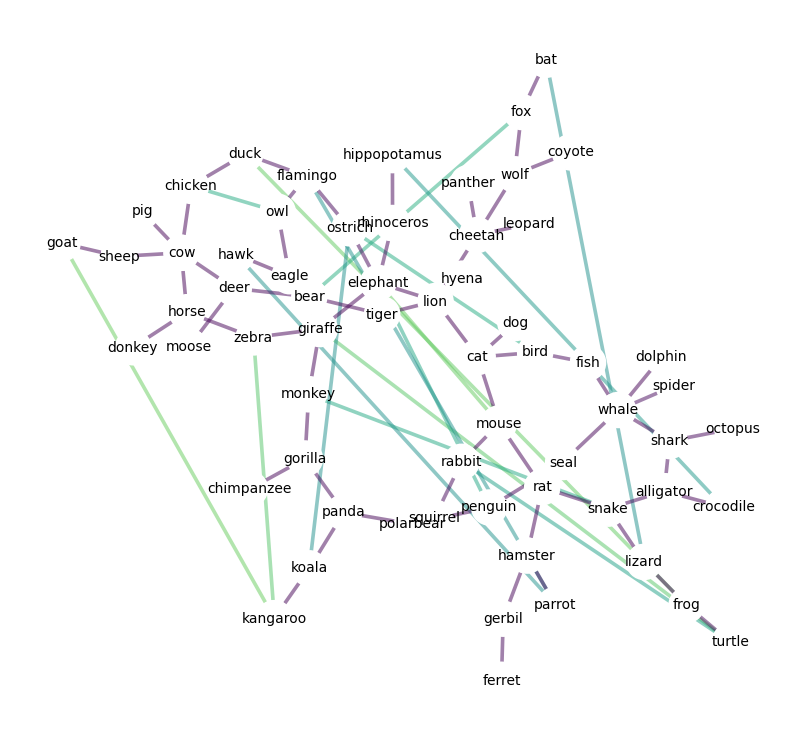

In [239]:
# f.savefig('animals.svg')
from netgraph import Graph, InteractiveGraph
from affinis.filter import threshold_edges_filter
plt.figure(figsize=(10,10))
Graph(
    # _sq(min_connected_filter(_sq(Gvals:=(_sq(evd_L)))).filled(0)),
    Gneg,
    # _sq((threshold_edges_filter(_sq(Gvals), 0.9) - Gthres.min()).filled(0)),
    # node_labels=dict(enumerate(animals.columns)),
    node_labels=True,
    # scale = (3,3),
    node_layout=nx.kamada_kawai_layout(G), 
    # node_layout_kwargs=dict(k=0.1),
    node_size=5, 
    # total_iterations=100,
    # node_labels=True,
    node_label_offset = 0.001, 
    node_edge_color='w',
    # node_shape='o',
    edge_cmap='viridis_r'
    # edge_layout='curved', 
    # edge_layout_kwargs=dict(k=0.05),
    # edge_layout='bundled'

)
plt.show()

In [241]:
from pyvis.network import Network
nt = Network('500px','500px')
nt.from_nx(G)
nt.show('nx.html')

nx.html


AttributeError: 'NoneType' object has no attribute 'render'

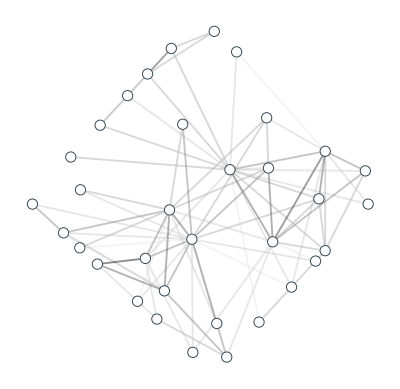

In [58]:
Graph(
    K, 
    scale=(2,2),
    node_layout="spring", 
    node_layout_kwargs=dict(k=0.5)
)

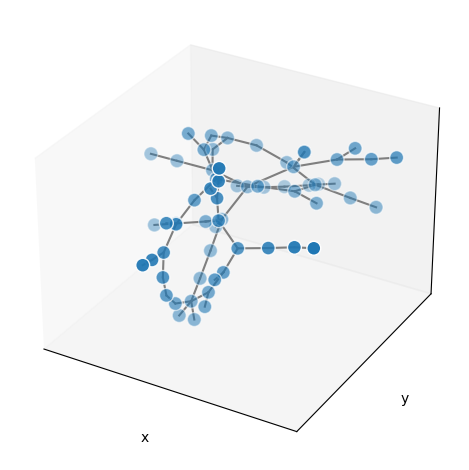

In [65]:
from mpl_toolkits.mplot3d import Axes3D

# The graph to visualize
# G = nx.cycle_graph(20)

# 3d spring layout
pos3 = nx.spring_layout(G, dim=3)
# Extract node and edge positions from the layout
node_xyz = np.array([pos3[v] for v in sorted(G)])
edge_xyz = np.array([(pos3[u], pos3[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
# plt.show()

NameError: name 'E_obs' is not defined

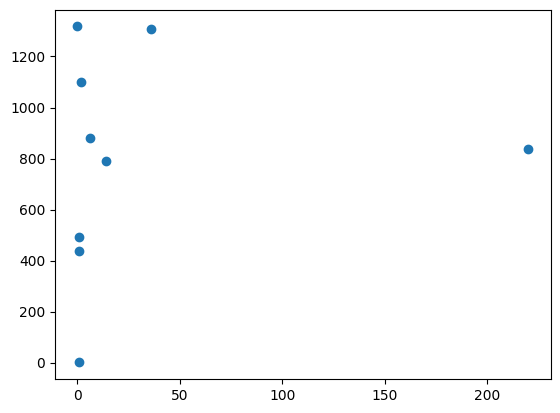

In [20]:
import scipy.stats as ss
# ss.rv_histogram(
cts,vals=np.histogram(unroll_node_obs(X).sum(axis=0), density=False, 
# bins=np.arange(unroll_node_obs(X).sum(axis=0).max())
)

plt.plot(cts[1:], robbins_cooc:=((vals[1:-1]+1)*cts[:-1]+0.5)/(cts[1:]+1), ls='', marker='o') #robbins estimate
    # , density=False).pdf(range(1000))

cts,vals=np.histogram(E_obs.sum(axis=0), density=False, 
# bins=np.arange(E_obs.sum(axis=0).max())
)
# plt.plot(cts[1:], robbins_intr:=((vals[1:-1]+1)*cts[:-1]+0.5)/(cts[1:]+1), ls='', marker='o') #robbins estimate
# plt.yscale('log')

(7.0, 0.008350344367879032)

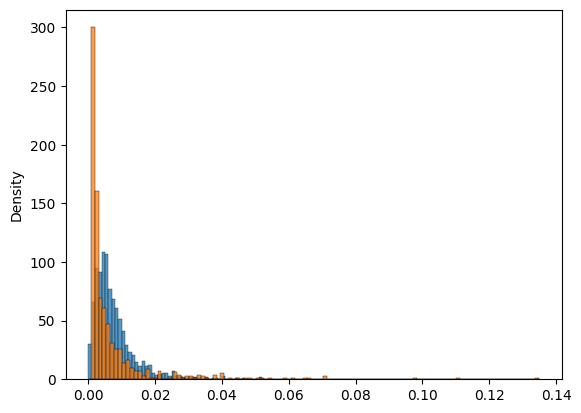

In [16]:
from scipy.stats import poisson, nbinom, dirichlet
from scipy.special import lambertw

# _sq(1-poisson(mst_post).pmf(0))/forest(_norm_diag((lambda a: np.diag(a.sum(axis=0))-a)(_sq(mst_post))), beta=10)

# m = X.shape[1]*(E_obs.sum(axis=0)+0.5)/_sq(X.T@X+1)
# m = E_obs.sum(axis=0)/np.ma.masked_less(_sq(X.T@X),1)
# s = m/((E_obs>0).sum(axis=0)/np.ma.masked_less(_sq(X.T@X), 1))
# lam = (lambda s: lambertw(-s*np.exp(-s))+s)(s)
# 1-s/np.real(lam)   
# s, lam

# lambertw(-mst_post*np.exp(-mst_post))+mst_post
# mst_post
# E_obs.mean(axis=0)/E_obs.nonzero().mean(axis=0)
# (E_obs>0).mean(axis=0)
# m/((E_obs>0).sum(axis=0)/np.ma.masked_less(_sq(X.T@X), 1))
# np.real(lam)
# m
E_obs_ma = np.ma.masked_array(E_obs.todense(), mask=~(unroll_node_obs(X).astype(bool)))

bss = poisson(1).rvs((E_obs.shape[0], 1000))
m = (poisson(1).rvs((E_obs.shape[0], 1000)).sum(axis=1)*E_obs_ma.T).T.mean(axis=0)/1000
s = m/(m>0).sum(axis=0)
lam = (lambda s: lambertw(-s*np.exp(-s))+s)(s)
# 1-s/np.real(lam)   
# sns.histplot(np.real(lam))
sns.histplot(unroll_node_obs(X).sum(axis=0)/X.shape[0], stat='density')
sns.histplot(E_obs.sum(axis=0)[E_obs.sum(axis=0)>5]/X.shape[0], stat='density')
# plt.plot(poisson(unroll_node_obs(X).sum(axis=0).mean()/X.shape[0]).pmf(np.arange(200)))
# plt.plot(nbinom(7, 0.5).pmf(np.arange(50)), color='r')
# sns.histplot(E_obs.sum(axis=0)[E_obs.sum(axis=0)>0], stat='probability', discrete=True)
# lam

# sns.histplot(nbinom(4, 0.1).mean(axis=0)>0], stat='probability', discrete=True)
# lam

nbinom(7, 0.5).mean(), unroll_node_obs(X).sum(axis=0).mean()/X.shape[0]
# m
# sns.histplot((E_obs.sum(axis=0)+0.5)/(unroll_node_obs(X).sum(axis=0)+1), stat='density')
# (unroll_node_obs(X).astype(bool)).shape, E_obs.shape
# plt.yscale('log')


In [17]:
# sns.histplot(_sq(ochiai(X.shape[0]*dirichlet(4*np.ones(X.shape[0])).rvs().T*X))
ochiai(rng.choice(X, axis=0, size=1000, p=dirichlet(4*np.ones(X.shape[0])).rvs()[0]), pseudocts=0.5)
# dirichlet(4*np.ones(X.shape[0])).rvs()[0]

# ochiai(X)

array([[1.        , 0.42725825, 0.18772199, ..., 0.2149575 , 0.04922865,
        0.05379177],
       [0.42725825, 1.        , 0.23315936, ..., 0.2058011 , 0.08948682,
        0.05123052],
       [0.18772199, 0.23315936, 1.        , ..., 0.08423156, 0.11597592,
        0.00745258],
       ...,
       [0.2149575 , 0.2058011 , 0.08423156, ..., 1.        , 0.00825215,
        0.08111125],
       [0.04922865, 0.08948682, 0.11597592, ..., 0.00825215, 1.        ,
        0.04015834],
       [0.05379177, 0.05123052, 0.00745258, ..., 0.08111125, 0.04015834,
        1.        ]])

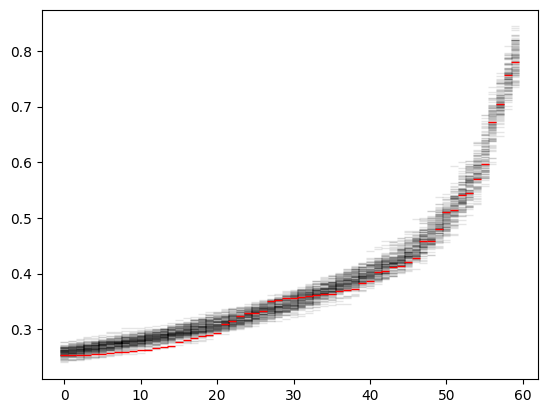

In [18]:
for i in range(100):
    plt.plot(np.sort(_sq(
        ochiai(rng.choice(X, axis=0, size=1000, p=dirichlet(4*np.ones(X.shape[0])).rvs()[0]), pseudocts=0.5)
        ))[-60:], 
        marker='_', ls='', color='k', alpha=0.1
    )
plt.plot(np.sort(_sq(ochiai(X, pseudocts=0.5)))[-60:], marker='_', ls='', color='r')

<Axes: >

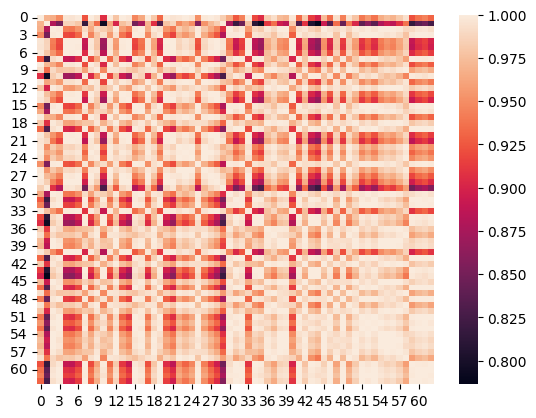

In [19]:
# from affinis.plots import hinton
from affinis.utils import minmax
from affinis.associations import _contingency_prob

a,b,c,d = _contingency_prob(X, pseudocts=0.5)

d/b, d/c, a.shape
# sns.heatmap(1/_outer(np.add, 1/X.sum(axis=0)))
# sns.heatmap(sinkhorn(_sq(post_L)))
# sns.histplot(post_L)
# sns.histplot(minmax(_sq(sinkhorn(_sq(post_L)))))
sns.heatmap((1/_outer(np.add, 1/X.sum(axis=0)))/(np.sqrt(_outer(np.multiply, X.sum(axis=0)))/2))

<Axes: >

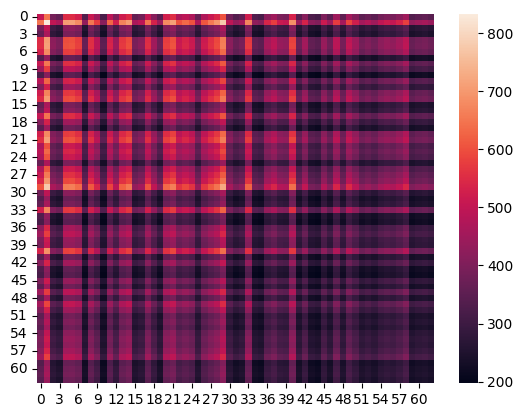

In [20]:
sns.heatmap(np.sqrt(_outer(np.multiply, X.sum(axis=0)))/2)

In [21]:
# sns.histplot(post_L, stat='density')
# sns.histplot(np.where(mst_post>0.1, mst_post, np.nan), stat='density')
# _sq(mst_post).shape
# plt.xscale('log')
# mst_post

<Axes: ylabel='Count'>

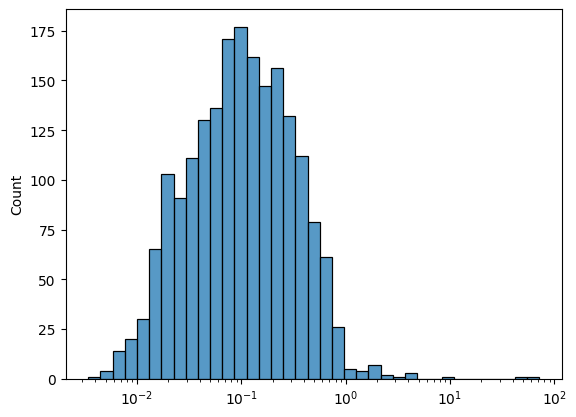

In [22]:
sns.histplot(post_L/_sq(ochiai(X, pseudocts=0.5)), log_scale=True)

In [32]:
# matplotlib.use('nbagg')

from netgraph import Graph, InteractiveGraph, EditableGraph
# %matplotlib widget
plt.figure(figsize=(15,15))

gplot=InteractiveGraph(
    _sq(min_connected_filter(_sq(Gvals)).filled(0)), 
    node_labels=True, 
    node_layout='dot', 
    # node_label_offset=0.05,
    node_size=2,
    directed=False,
)
plt.show()
# dict(zip(map(tuple, np.vstack(np.triu_indices_from(Gvals)).T.tolist()), 1-min_connected_filter(_sq(Gvals)).filled(0)))

# generalized_graph_dists(edge_mask_to_laplacian(min_connected_filter(_sq(Gvals))))

<IPython.core.display.Javascript object>

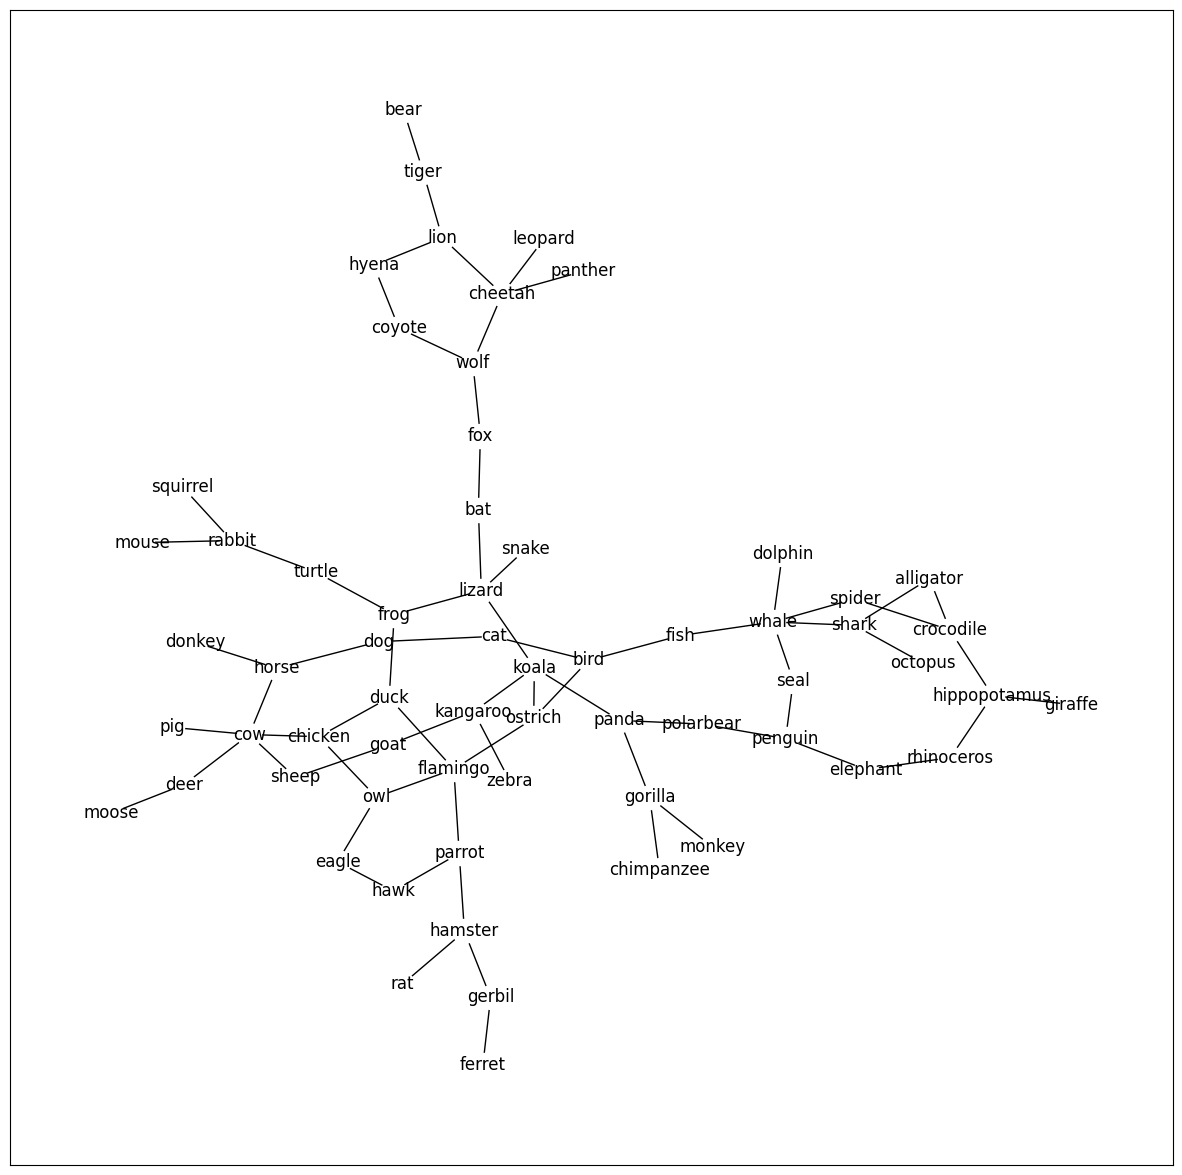

In [27]:
# sns.displot(mst_post)
# _sq(mst_post>0.1)
plt.figure(figsize=(15,15))

# G = nx.from_pandas_adjacency(pd.DataFrame((minmax(sinkhorn(_sq(post_L)))>0.7).astype(int), index=animals.columns, columns=animals.columns))
# G = nx.from_pandas_adjacency(pd.DataFrame(_sq(_sq(top_tree_pct(_sq(post_L), mult=1.5))), index=animals.columns, columns=animals.columns))

G = nx.from_pandas_adjacency(pd.DataFrame(_sq(~min_connected_filter(_sq(Gvals:=(_sq(post_L)))).mask), index=animals.columns, columns=animals.columns))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=pos, node_color='w')
# nx.draw_networkx_edges(G, pos=pos, edge_cmap='viridis')

In [26]:
from affinis.utils import _outer
def unroll_node_obs(X): 
    trirow, tricol = np.triu_indices(n=X.shape[1],k=1)
    return np.einsum('ij,ik->ijk', X, X)[:,trirow, tricol]
    
np.ma.array(np.multiply.outer(np.ones(roll_X.shape[0]), _sq(ochiai(roll_X))), mask=unroll_node_obs(~roll_X.astype(bool)))
# x_mask= np.ma.masked_less(X[0], 1e-3)
# x_umsk= X[0]
# %timeit _outer(np.multiply,x_mask.compressed())
# %timeit _outer(np.multiply, x_umsk)
# x_mask.

# unroll_node_obs(roll_X)[0].sum()
# np.ma.masked_array(X.astype(bool))

masked_array(
  data=[[0.40418705569182345, 0.19166467262861223, 0.03793161260281295,
         ..., --, --, --],
        [0.40418705569182345, 0.19166467262861223, 0.03793161260281295,
         ..., --, --, --],
        [--, 0.19166467262861223, 0.03793161260281295, ..., --, --, --],
        ...,
        [--, --, --, ..., --, 0.08483731055787307, 0.09947758530662153],
        [--, --, --, ..., --, 0.08483731055787307, 0.09947758530662153],
        [--, --, --, ..., 0.039126049762281005, 0.08483731055787307,
         0.09947758530662153]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20)

/tmp/ipykernel_2689862/2617462368.py:6: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(nx.difference(G, Gtree),


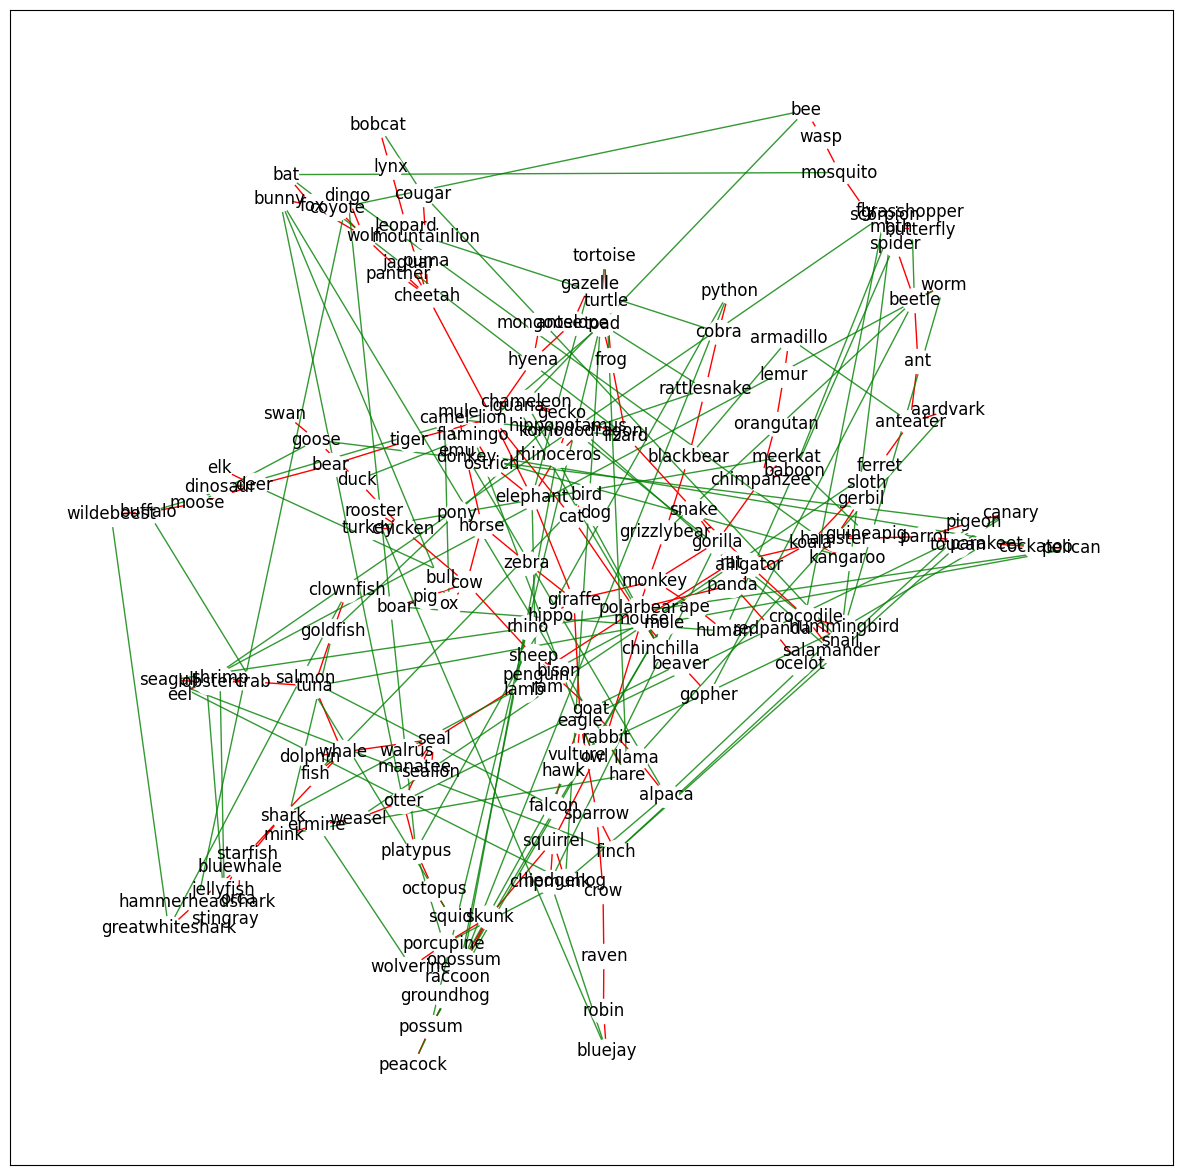

In [144]:
from scipy.sparse.csgraph import minimum_spanning_tree
plt.figure(figsize=(15,15))
Gtree = nx.from_pandas_adjacency(pd.DataFrame(minimum_spanning_tree(-Gvals).todense()<0, index=animals.columns, columns=animals.columns))
pos = nx.spring_layout(Gtree)
nx.draw_networkx(Gtree, pos=pos, node_color='w', edge_color='r')
nx.draw_networkx_edges(nx.difference(G, Gtree), 
    pos=pos, edge_color='g', alpha=0.8,
    connectionstyle="arc3,rad=0.01"  # <-- THIS IS IT
)
# nx.difference()

In [ ]:
from toolz import sliding_window
# df.query('category=="animals"').groupby(['listnum','item'])['item'].rolling(2).count()
# animals.rolling(2).sum()
(df
 .reset_index(level=1, drop=True)
 .set_index(
    df
    .groupby(level=0)
    .cumcount()
    .rename('tokenid'), 
    append=True
    )['item']
#  .groupby(['item'])['item']
 .rolling(2)
 .apply(str.join(', '))
#  .count()
#  .rolling(2)
#  .count()
#  .unique()
)

TypeError: str.join() takes exactly one argument (0 given)

In [22]:
# ochiai(roll_X)
np.cross(roll_X, roll_X)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)